# Ordering by metrics and retraining phase

## Dataset: Intel

## Configuration 2
	2. Incremental guided retraining starting from the original model using the new adversarial inputs and original training set.
    

In [ ]:
pip install --user tensorflow==2.5

In [1]:
import argparse

import numpy as np
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt


from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2

import glob
import os
import cv2
import keras


import time
import argparse

from tqdm import tqdm

from keras.models import load_model, Model


In [ ]:
cd '../utils'

In [2]:
# utils for project
import utils_guided_retraining as utils

In [ ]:
cd '../notebooks/'

In [3]:
x_train,y_train = utils.get_data("intel","Train")
x_val,y_val = utils.get_data("intel","Val")
x_test,y_test = utils.get_data("intel","Test")

In [4]:
x_train_and_adversary,y_train_and_adversary = utils.get_data("intel","Train_and_adversary")

In [5]:
x_adversary_training = x_train_and_adversary[len(x_train):]
print(len(x_adversary_training))
y_adversary_training = y_train_and_adversary[len(y_train):]

print(len(y_adversary_training))

3000
3000


In [6]:
# Obtaining adversarial examples for testing 
x_test_and_adversary,y_test_and_adversary = utils.get_adversarial_data("intel",'Test_fgsm') 

In [7]:
x_adversary_test_fgsm = x_test_and_adversary[len(x_test):]
print(len(x_adversary_test_fgsm))
y_adversary_test_fgsm = y_test_and_adversary[len(y_test):]

print(len(y_adversary_test_fgsm))

3000
3000


## ----

In [8]:
# Original model 
model_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/intel_model_21_10/"


In [9]:
model_original = utils.My_model("intel",True, model_dir)

Model loaded correctly


In [11]:
model_original.evaluate(x_test,y_test)

94/94 [==============================] - 12s 22ms/step - loss: 0.5392 - accuracy: 0.8037


[0.5391883850097656, 0.8036666512489319]

In [13]:
model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm)

94/94 [==============================] - 2s 23ms/step - loss: 3.1384 - accuracy: 0.1497


[3.138401746749878, 0.1496666669845581]

In [ ]:
model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm)

## Obtaining new LSA and DSA values 

In [10]:
save_dir_lsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/intel_lsa_values_2.npy"


save_dir_dsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/intel_dsa_values_2.npy"

target_lsa = np.load(save_dir_lsa)
target_dsa = np.load(save_dir_dsa)

In [11]:
lsa_values = target_lsa
dsa_values = target_dsa

In [12]:

# Obtaining top n images by LSA values
top_images_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),x_train_and_adversary)
top_labels_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),y_train_and_adversary)


In [13]:

top_images_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),x_train_and_adversary)
top_labels_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),y_train_and_adversary)


In [14]:
len(top_images_by_lsa)//20

711

In [15]:
top_images_by_lsa_5000 = np.array(top_images_by_lsa[:5000])
top_labels_by_lsa_5000 = np.array(top_labels_by_lsa[:5000])



In [112]:
m = 700
n = 0
image_sets_lsa = []
label_sets_lsa = []


for i in range(len(top_images_by_lsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_lsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_lsa)%m))
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m])
    image_sets_lsa.append(top_images_by_lsa_n)
    label_sets_lsa.append(top_labels_by_lsa_n)
    print(len(top_images_by_lsa_n))
    n += m



0 :
0  ->  700
700
1 :
0  ->  1400
1400
2 :
0  ->  2100
2100
3 :
0  ->  2800
2800
4 :
0  ->  3500
3500
5 :
0  ->  4200
4200
6 :
0  ->  4900
4900
7 :
0  ->  5600
5600
8 :
0  ->  6300
6300
9 :
0  ->  7000
7000
10 :
0  ->  7700
7700
11 :
0  ->  8400
8400
12 :
0  ->  9100
9100
13 :
0  ->  9800
9800
14 :
0  ->  10500
10500
15 :
0  ->  11200
11200
16 :
0  ->  11900
11900
17 :
0  ->  12600
12600
18 :
0  ->  13300
13300
19 :
Last
0  ->  14224
14224


## Training guided by LSA

In [17]:
dataset = 'intel'

In [18]:
model_lsa_5000 =  utils.My_model(dataset,True,model_dir)
model_lsa_5000.compile_model()

Model loaded correctly
Model compiled


In [19]:
model_lsa_5000.fit_model(top_images_by_lsa_5000,top_labels_by_lsa_5000,x_val,y_val)

Epoch 1/10
79/79 [==============================] - 29s 176ms/step - loss: 1.1935 - accuracy: 0.5353 - val_loss: 0.8302 - val_accuracy: 0.6701
Epoch 2/10
79/79 [==============================] - 13s 169ms/step - loss: 0.9267 - accuracy: 0.6339 - val_loss: 1.0896 - val_accuracy: 0.5899
Epoch 3/10
79/79 [==============================] - 14s 172ms/step - loss: 0.8681 - accuracy: 0.6547 - val_loss: 1.0818 - val_accuracy: 0.5913
Epoch 4/10
79/79 [==============================] - 13s 171ms/step - loss: 0.8098 - accuracy: 0.6864 - val_loss: 0.9624 - val_accuracy: 0.6316
Epoch 5/10
79/79 [==============================] - 13s 170ms/step - loss: 0.8086 - accuracy: 0.6873 - val_loss: 1.4199 - val_accuracy: 0.4583
Epoch 6/10
79/79 [==============================] - 13s 169ms/step - loss: 0.7126 - accuracy: 0.7243 - val_loss: 1.0978 - val_accuracy: 0.6031
Epoch 7/10
79/79 [==============================] - 13s 167ms/step - loss: 0.6787 - accuracy: 0.7435 - val_loss: 0.9577 - val_accuracy: 0.6337

In [108]:
for i in range(7):
    print(i)
    models_lsa[i] =  utils.My_model('intel',True,model_dir)
    models_lsa[i].compile_model()

0
Model loaded correctly
Model compiled
1
Model loaded correctly
Model compiled
2
Model loaded correctly
Model compiled
3
Model loaded correctly
Model compiled
4
Model loaded correctly
Model compiled
5
Model loaded correctly
Model compiled
6
Model loaded correctly
Model compiled


In [110]:
models_lsa[1].evaluate(x_test,y_test)

94/94 [==============================] - 3s 24ms/step - loss: 0.4941 - accuracy: 0.8294


[0.5391883850097656, 0.8036666512489319]

In [26]:
print(model_dir)

models_lsa = []
for i in range(len(label_sets_lsa)):
    print(i,":")
    model = utils.My_model('intel',True,model_dir)
    model.compile_model()
    models_lsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/intel_model_21_10/
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [27]:
print(len(models_lsa))


20


In [113]:
n = 0
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
6/6 [==============================] - 5s 636ms/step - loss: 2.0641 - accuracy: 0.2457 - val_loss: 1.1151 - val_accuracy: 0.5603
Epoch 2/20
6/6 [==============================] - 4s 639ms/step - loss: 1.4756 - accuracy: 0.3757 - val_loss: 0.9574 - val_accuracy: 0.7036
Epoch 3/20
6/6 [==============================] - 4s 638ms/step - loss: 1.3338 - accuracy: 0.4529 - val_loss: 0.8454 - val_accuracy: 0.7304
Epoch 4/20
6/6 [==============================] - 4s 678ms/step - loss: 1.4258 - accuracy: 0.4214 - val_loss: 0.9247 - val_accuracy: 0.6740
Epoch 5/20
6/6 [==============================] - 4s 673ms/step - loss: 1.1768 - accuracy: 0.5457 - val_loss: 0.8539 - val_accuracy: 0.6994
Epoch 6/20
6/6 [==============================] - 4s 635ms/step - loss: 1.1639 - accuracy: 0.5343 - val_loss: 0.8525 - val_accuracy: 0.7072
Epoch 7/20
6/6 [==============================] - 3s 636ms/step - loss: 1.1793 - accuracy: 0.5486 - val_loss: 0.9379 - val_accuracy: 0.6883
Epoch 8/20
6/6 [====

In [114]:
n = 1
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
11/11 [==============================] - 7s 482ms/step - loss: 1.8946 - accuracy: 0.3236 - val_loss: 1.1215 - val_accuracy: 0.6462
Epoch 2/20
11/11 [==============================] - 5s 484ms/step - loss: 1.2982 - accuracy: 0.4771 - val_loss: 0.9860 - val_accuracy: 0.6480
Epoch 3/20
11/11 [==============================] - 5s 480ms/step - loss: 1.1976 - accuracy: 0.5364 - val_loss: 0.9669 - val_accuracy: 0.6558
Epoch 4/20
11/11 [==============================] - 5s 481ms/step - loss: 1.1207 - accuracy: 0.5643 - val_loss: 0.8854 - val_accuracy: 0.6819
Epoch 5/20
11/11 [==============================] - 5s 490ms/step - loss: 1.1931 - accuracy: 0.5471 - val_loss: 0.9150 - val_accuracy: 0.6626
Epoch 6/20
11/11 [==============================] - 5s 478ms/step - loss: 1.0171 - accuracy: 0.6157 - val_loss: 1.1086 - val_accuracy: 0.5913
Epoch 7/20
11/11 [==============================] - 5s 475ms/step - loss: 0.9804 - accuracy: 0.6400 - val_loss: 0.8846 - val_accuracy: 0.6612
Epoch 

In [115]:
n = 2
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
17/17 [==============================] - 9s 454ms/step - loss: 1.8661 - accuracy: 0.3703 - val_loss: 0.8873 - val_accuracy: 0.6826
Epoch 2/20
17/17 [==============================] - 7s 404ms/step - loss: 1.1814 - accuracy: 0.5126 - val_loss: 0.9045 - val_accuracy: 0.7008
Epoch 3/20
17/17 [==============================] - 7s 407ms/step - loss: 1.0810 - accuracy: 0.5562 - val_loss: 1.2201 - val_accuracy: 0.5535
Epoch 4/20
17/17 [==============================] - 7s 426ms/step - loss: 1.1343 - accuracy: 0.5553 - val_loss: 0.9419 - val_accuracy: 0.6612
Epoch 5/20
17/17 [==============================] - 8s 468ms/step - loss: 1.0833 - accuracy: 0.5747 - val_loss: 1.0173 - val_accuracy: 0.6312
Epoch 6/20
17/17 [==============================] - 8s 453ms/step - loss: 0.9682 - accuracy: 0.6209 - val_loss: 0.8684 - val_accuracy: 0.6944
Epoch 7/20
17/17 [==============================] - 8s 461ms/step - loss: 0.9501 - accuracy: 0.6100 - val_loss: 1.0084 - val_accuracy: 0.6059
Epoch 

In [116]:
n = 3
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
22/22 [==============================] - 11s 428ms/step - loss: 1.5531 - accuracy: 0.4740 - val_loss: 0.8377 - val_accuracy: 0.7068
Epoch 2/20
22/22 [==============================] - 9s 417ms/step - loss: 0.9646 - accuracy: 0.6090 - val_loss: 0.8973 - val_accuracy: 0.6858
Epoch 3/20
22/22 [==============================] - 9s 428ms/step - loss: 0.9248 - accuracy: 0.6363 - val_loss: 0.8556 - val_accuracy: 0.6865
Epoch 4/20
22/22 [==============================] - 9s 409ms/step - loss: 0.8847 - accuracy: 0.6510 - val_loss: 0.8897 - val_accuracy: 0.6858
Epoch 5/20
22/22 [==============================] - 9s 410ms/step - loss: 0.8457 - accuracy: 0.6793 - val_loss: 0.9218 - val_accuracy: 0.6455
Epoch 6/20
22/22 [==============================] - 9s 412ms/step - loss: 0.8002 - accuracy: 0.6896 - val_loss: 1.1707 - val_accuracy: 0.5271
Epoch 7/20
22/22 [==============================] - 9s 409ms/step - loss: 0.8258 - accuracy: 0.6888 - val_loss: 1.0025 - val_accuracy: 0.5956
Epoch

In [117]:
n = 4
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
28/28 [==============================] - 15s 416ms/step - loss: 1.3594 - accuracy: 0.5072 - val_loss: 1.0544 - val_accuracy: 0.6031
Epoch 2/20
28/28 [==============================] - 12s 420ms/step - loss: 0.9471 - accuracy: 0.6356 - val_loss: 0.8675 - val_accuracy: 0.7165
Epoch 3/20
28/28 [==============================] - 11s 407ms/step - loss: 0.8981 - accuracy: 0.6602 - val_loss: 1.1100 - val_accuracy: 0.5681
Epoch 4/20
28/28 [==============================] - 11s 390ms/step - loss: 0.8470 - accuracy: 0.6838 - val_loss: 0.9087 - val_accuracy: 0.6869
Epoch 5/20
28/28 [==============================] - 12s 416ms/step - loss: 0.8293 - accuracy: 0.6881 - val_loss: 0.8904 - val_accuracy: 0.6555
Epoch 6/20
28/28 [==============================] - 10s 374ms/step - loss: 0.7493 - accuracy: 0.7252 - val_loss: 1.1010 - val_accuracy: 0.5414
Epoch 7/20
28/28 [==============================] - 10s 373ms/step - loss: 0.7674 - accuracy: 0.7181 - val_loss: 1.0420 - val_accuracy: 0.5642

In [118]:
n = 5
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
33/33 [==============================] - 15s 396ms/step - loss: 1.5245 - accuracy: 0.4783 - val_loss: 0.8874 - val_accuracy: 0.7019
Epoch 2/20
33/33 [==============================] - 13s 385ms/step - loss: 0.9869 - accuracy: 0.6223 - val_loss: 0.9243 - val_accuracy: 0.6669
Epoch 3/20
33/33 [==============================] - 13s 380ms/step - loss: 0.9366 - accuracy: 0.6428 - val_loss: 0.9287 - val_accuracy: 0.6501
Epoch 4/20
33/33 [==============================] - 13s 391ms/step - loss: 0.9052 - accuracy: 0.6534 - val_loss: 0.9730 - val_accuracy: 0.6041
Epoch 5/20
33/33 [==============================] - 13s 384ms/step - loss: 0.8564 - accuracy: 0.6722 - val_loss: 0.8483 - val_accuracy: 0.6805
Epoch 6/20
33/33 [==============================] - 12s 369ms/step - loss: 0.8124 - accuracy: 0.6891 - val_loss: 1.0211 - val_accuracy: 0.5852
Epoch 7/20
33/33 [==============================] - 2494s 78s/step - loss: 0.7682 - accuracy: 0.7008 - val_loss: 0.9547 - val_accuracy: 0.6180

In [119]:
n = 6
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
39/39 [==============================] - 16s 368ms/step - loss: 1.2959 - accuracy: 0.5116 - val_loss: 1.0358 - val_accuracy: 0.6220
Epoch 2/20
39/39 [==============================] - 14s 353ms/step - loss: 0.9867 - accuracy: 0.6167 - val_loss: 1.1220 - val_accuracy: 0.5806
Epoch 3/20
39/39 [==============================] - 14s 356ms/step - loss: 0.9196 - accuracy: 0.6397 - val_loss: 0.9736 - val_accuracy: 0.6637
Epoch 4/20
39/39 [==============================] - 14s 361ms/step - loss: 0.8998 - accuracy: 0.6487 - val_loss: 0.8598 - val_accuracy: 0.6737
Epoch 5/20
39/39 [==============================] - 14s 360ms/step - loss: 0.8201 - accuracy: 0.6734 - val_loss: 0.9242 - val_accuracy: 0.6701
Epoch 6/20
39/39 [==============================] - 14s 353ms/step - loss: 0.7887 - accuracy: 0.6901 - val_loss: 1.0069 - val_accuracy: 0.6580
Epoch 7/20
39/39 [==============================] - 14s 354ms/step - loss: 0.7982 - accuracy: 0.6908 - val_loss: 0.8798 - val_accuracy: 0.6887

In [40]:
n = 7
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
44/44 [==============================] - 16s 338ms/step - loss: 1.0141 - accuracy: 0.6048 - val_loss: 0.7934 - val_accuracy: 0.7322
Epoch 2/20
44/44 [==============================] - 14s 322ms/step - loss: 0.8564 - accuracy: 0.6668 - val_loss: 0.8025 - val_accuracy: 0.7161
Epoch 3/20
44/44 [==============================] - 14s 324ms/step - loss: 0.8062 - accuracy: 0.6920 - val_loss: 0.7807 - val_accuracy: 0.7200
Epoch 4/20
44/44 [==============================] - 15s 334ms/step - loss: 0.7598 - accuracy: 0.7039 - val_loss: 0.9071 - val_accuracy: 0.6587
Epoch 5/20
44/44 [==============================] - 14s 326ms/step - loss: 0.7213 - accuracy: 0.7175 - val_loss: 1.0161 - val_accuracy: 0.5956
Epoch 6/20
44/44 [==============================] - 14s 328ms/step - loss: 0.6876 - accuracy: 0.7311 - val_loss: 2.0429 - val_accuracy: 0.4198
Epoch 7/20
44/44 [==============================] - 14s 325ms/step - loss: 0.6943 - accuracy: 0.7312 - val_loss: 1.3482 - val_accuracy: 0.5011

In [41]:
n = 8
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
50/50 [==============================] - 18s 333ms/step - loss: 1.0302 - accuracy: 0.6033 - val_loss: 0.8136 - val_accuracy: 0.7468
Epoch 2/20
50/50 [==============================] - 16s 316ms/step - loss: 0.8675 - accuracy: 0.6563 - val_loss: 1.5622 - val_accuracy: 0.4490
Epoch 3/20
50/50 [==============================] - 16s 319ms/step - loss: 0.7999 - accuracy: 0.6937 - val_loss: 0.9258 - val_accuracy: 0.6473
Epoch 4/20
50/50 [==============================] - 16s 318ms/step - loss: 0.7712 - accuracy: 0.6997 - val_loss: 0.7783 - val_accuracy: 0.7165
Epoch 5/20
50/50 [==============================] - 16s 318ms/step - loss: 0.7258 - accuracy: 0.7156 - val_loss: 0.9879 - val_accuracy: 0.6230
Epoch 6/20
50/50 [==============================] - 16s 317ms/step - loss: 0.6963 - accuracy: 0.7286 - val_loss: 1.0448 - val_accuracy: 0.6284
Epoch 7/20
50/50 [==============================] - 16s 318ms/step - loss: 0.6679 - accuracy: 0.7468 - val_loss: 0.9360 - val_accuracy: 0.6327

In [42]:
n = 9
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
55/55 [==============================] - 19s 324ms/step - loss: 1.0165 - accuracy: 0.5970 - val_loss: 0.7971 - val_accuracy: 0.7372
Epoch 2/20
55/55 [==============================] - 17s 318ms/step - loss: 0.8632 - accuracy: 0.6559 - val_loss: 0.9980 - val_accuracy: 0.6555
Epoch 3/20
55/55 [==============================] - 18s 331ms/step - loss: 0.8279 - accuracy: 0.6780 - val_loss: 0.7247 - val_accuracy: 0.7447
Epoch 4/20
55/55 [==============================] - 17s 319ms/step - loss: 0.8013 - accuracy: 0.6854 - val_loss: 0.9289 - val_accuracy: 0.6448
Epoch 5/20
55/55 [==============================] - 18s 320ms/step - loss: 0.7616 - accuracy: 0.7109 - val_loss: 0.7194 - val_accuracy: 0.7536
Epoch 6/20
55/55 [==============================] - 18s 322ms/step - loss: 0.7236 - accuracy: 0.7193 - val_loss: 0.7984 - val_accuracy: 0.6879
Epoch 7/20
55/55 [==============================] - 18s 323ms/step - loss: 0.6860 - accuracy: 0.7327 - val_loss: 0.7932 - val_accuracy: 0.6851

In [43]:
n = 10
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
61/61 [==============================] - 22s 328ms/step - loss: 0.9818 - accuracy: 0.6234 - val_loss: 0.8760 - val_accuracy: 0.7040
Epoch 2/20
61/61 [==============================] - 19s 315ms/step - loss: 0.8478 - accuracy: 0.6725 - val_loss: 0.8838 - val_accuracy: 0.6737
Epoch 3/20
61/61 [==============================] - 19s 315ms/step - loss: 0.8165 - accuracy: 0.6843 - val_loss: 0.8286 - val_accuracy: 0.6648
Epoch 4/20
61/61 [==============================] - 19s 315ms/step - loss: 0.7676 - accuracy: 0.7048 - val_loss: 0.9776 - val_accuracy: 0.6316
Epoch 5/20
61/61 [==============================] - 19s 317ms/step - loss: 0.7404 - accuracy: 0.7144 - val_loss: 1.0183 - val_accuracy: 0.5981
Epoch 6/20
61/61 [==============================] - 19s 318ms/step - loss: 0.7205 - accuracy: 0.7239 - val_loss: 0.7239 - val_accuracy: 0.7290
Epoch 7/20
61/61 [==============================] - 19s 317ms/step - loss: 0.6916 - accuracy: 0.7312 - val_loss: 0.9580 - val_accuracy: 0.6202

In [44]:
n = 11
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
66/66 [==============================] - 23s 319ms/step - loss: 0.9548 - accuracy: 0.6389 - val_loss: 0.8210 - val_accuracy: 0.7154
Epoch 2/20
66/66 [==============================] - 21s 313ms/step - loss: 0.8450 - accuracy: 0.6792 - val_loss: 0.8767 - val_accuracy: 0.6537
Epoch 3/20
66/66 [==============================] - 21s 313ms/step - loss: 0.7912 - accuracy: 0.6932 - val_loss: 0.7726 - val_accuracy: 0.7133
Epoch 4/20
66/66 [==============================] - 21s 311ms/step - loss: 0.7552 - accuracy: 0.7118 - val_loss: 0.7189 - val_accuracy: 0.7536
Epoch 5/20
66/66 [==============================] - 21s 312ms/step - loss: 0.7471 - accuracy: 0.7175 - val_loss: 0.8621 - val_accuracy: 0.6665
Epoch 6/20
66/66 [==============================] - 20s 311ms/step - loss: 0.6959 - accuracy: 0.7344 - val_loss: 0.7927 - val_accuracy: 0.6819
Epoch 7/20
66/66 [==============================] - 21s 311ms/step - loss: 0.6828 - accuracy: 0.7392 - val_loss: 0.7152 - val_accuracy: 0.7225

In [45]:
n = 12
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
72/72 [==============================] - 24s 307ms/step - loss: 0.9401 - accuracy: 0.6445 - val_loss: 0.7893 - val_accuracy: 0.7072
Epoch 2/20
72/72 [==============================] - 22s 307ms/step - loss: 0.8291 - accuracy: 0.6824 - val_loss: 0.8862 - val_accuracy: 0.6751
Epoch 3/20
72/72 [==============================] - 23s 317ms/step - loss: 0.7826 - accuracy: 0.7012 - val_loss: 0.8630 - val_accuracy: 0.6673
Epoch 4/20
72/72 [==============================] - 22s 301ms/step - loss: 0.7521 - accuracy: 0.7115 - val_loss: 0.7412 - val_accuracy: 0.7193
Epoch 5/20
72/72 [==============================] - 22s 302ms/step - loss: 0.7211 - accuracy: 0.7263 - val_loss: 0.7178 - val_accuracy: 0.7504
Epoch 6/20
72/72 [==============================] - 22s 301ms/step - loss: 0.7102 - accuracy: 0.7326 - val_loss: 0.7650 - val_accuracy: 0.7004
Epoch 7/20
72/72 [==============================] - 22s 302ms/step - loss: 0.6792 - accuracy: 0.7409 - val_loss: 0.8653 - val_accuracy: 0.6865

In [50]:
models_lsa[13] = utils.My_model('intel',True,model_dir)
models_lsa[13].compile_model()
models_lsa[14] = utils.My_model('intel',True,model_dir)
models_lsa[14].compile_model()

Model loaded correctly
Model compiled
Model loaded correctly
Model compiled


In [51]:
n = 13
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
77/77 [==============================] - 25s 303ms/step - loss: 1.0739 - accuracy: 0.6188 - val_loss: 0.8010 - val_accuracy: 0.7150
Epoch 2/20
77/77 [==============================] - 23s 297ms/step - loss: 0.8105 - accuracy: 0.6902 - val_loss: 0.6996 - val_accuracy: 0.7361
Epoch 3/20
77/77 [==============================] - 23s 298ms/step - loss: 0.7501 - accuracy: 0.7111 - val_loss: 0.6619 - val_accuracy: 0.7461
Epoch 4/20
77/77 [==============================] - 23s 297ms/step - loss: 0.7336 - accuracy: 0.7264 - val_loss: 0.7042 - val_accuracy: 0.7293
Epoch 5/20
77/77 [==============================] - 23s 302ms/step - loss: 0.7178 - accuracy: 0.7375 - val_loss: 0.7076 - val_accuracy: 0.7386
Epoch 6/20
77/77 [==============================] - 23s 300ms/step - loss: 0.6841 - accuracy: 0.7435 - val_loss: 0.8195 - val_accuracy: 0.7090
Epoch 7/20
77/77 [==============================] - 23s 300ms/step - loss: 0.6774 - accuracy: 0.7502 - val_loss: 0.7132 - val_accuracy: 0.7343

In [52]:
n = 14
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
83/83 [==============================] - 26s 299ms/step - loss: 0.9787 - accuracy: 0.6390 - val_loss: 1.0858 - val_accuracy: 0.6159
Epoch 2/20
83/83 [==============================] - 24s 293ms/step - loss: 0.8370 - accuracy: 0.6831 - val_loss: 0.7888 - val_accuracy: 0.7297
Epoch 3/20
83/83 [==============================] - 25s 295ms/step - loss: 0.8074 - accuracy: 0.6955 - val_loss: 0.8777 - val_accuracy: 0.6776
Epoch 4/20
83/83 [==============================] - 24s 294ms/step - loss: 0.7663 - accuracy: 0.7121 - val_loss: 0.8881 - val_accuracy: 0.6904
Epoch 5/20
83/83 [==============================] - 25s 296ms/step - loss: 0.7507 - accuracy: 0.7155 - val_loss: 0.8028 - val_accuracy: 0.7186
Epoch 6/20
83/83 [==============================] - 25s 296ms/step - loss: 0.7325 - accuracy: 0.7294 - val_loss: 1.7042 - val_accuracy: 0.4786
Epoch 7/20
83/83 [==============================] - 24s 294ms/step - loss: 0.7233 - accuracy: 0.7327 - val_loss: 0.7150 - val_accuracy: 0.7489

In [53]:
n = 15
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
88/88 [==============================] - 28s 298ms/step - loss: 0.9273 - accuracy: 0.6525 - val_loss: 0.6116 - val_accuracy: 0.7846
Epoch 2/20
88/88 [==============================] - 26s 299ms/step - loss: 0.8230 - accuracy: 0.6817 - val_loss: 0.7093 - val_accuracy: 0.7361
Epoch 3/20
88/88 [==============================] - 26s 295ms/step - loss: 0.7700 - accuracy: 0.7038 - val_loss: 0.6230 - val_accuracy: 0.7832
Epoch 4/20
88/88 [==============================] - 27s 302ms/step - loss: 0.7625 - accuracy: 0.7092 - val_loss: 0.6244 - val_accuracy: 0.7743
Epoch 5/20
88/88 [==============================] - 26s 298ms/step - loss: 0.7274 - accuracy: 0.7221 - val_loss: 0.6227 - val_accuracy: 0.7743
Epoch 6/20
88/88 [==============================] - 26s 297ms/step - loss: 0.7131 - accuracy: 0.7278 - val_loss: 0.7245 - val_accuracy: 0.7364
Epoch 7/20
88/88 [==============================] - 26s 296ms/step - loss: 0.6896 - accuracy: 0.7377 - val_loss: 0.5607 - val_accuracy: 0.7971

In [54]:
n = 16
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
93/93 [==============================] - 32s 325ms/step - loss: 0.8866 - accuracy: 0.6546 - val_loss: 0.5979 - val_accuracy: 0.7946
Epoch 2/20
93/93 [==============================] - 28s 297ms/step - loss: 0.7942 - accuracy: 0.6920 - val_loss: 0.5786 - val_accuracy: 0.7939
Epoch 3/20
93/93 [==============================] - 28s 300ms/step - loss: 0.7695 - accuracy: 0.7046 - val_loss: 0.6349 - val_accuracy: 0.7728
Epoch 4/20
93/93 [==============================] - 28s 302ms/step - loss: 0.7495 - accuracy: 0.7088 - val_loss: 0.6135 - val_accuracy: 0.7867
Epoch 5/20
93/93 [==============================] - 28s 296ms/step - loss: 0.7141 - accuracy: 0.7229 - val_loss: 0.5786 - val_accuracy: 0.7960
Epoch 6/20
93/93 [==============================] - 28s 296ms/step - loss: 0.7122 - accuracy: 0.7282 - val_loss: 0.7061 - val_accuracy: 0.7571
Epoch 7/20
93/93 [==============================] - 27s 295ms/step - loss: 0.6698 - accuracy: 0.7424 - val_loss: 0.6325 - val_accuracy: 0.7921

In [55]:
n = 17
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
99/99 [==============================] - 39s 363ms/step - loss: 0.8981 - accuracy: 0.6487 - val_loss: 0.7695 - val_accuracy: 0.7183
Epoch 2/20
99/99 [==============================] - 31s 314ms/step - loss: 0.8266 - accuracy: 0.6824 - val_loss: 0.7250 - val_accuracy: 0.7657
Epoch 3/20
99/99 [==============================] - 30s 303ms/step - loss: 0.7979 - accuracy: 0.6928 - val_loss: 0.8440 - val_accuracy: 0.7197
Epoch 4/20
99/99 [==============================] - 30s 303ms/step - loss: 0.7620 - accuracy: 0.7057 - val_loss: 0.6930 - val_accuracy: 0.7557
Epoch 5/20
99/99 [==============================] - 30s 301ms/step - loss: 0.7410 - accuracy: 0.7173 - val_loss: 0.6677 - val_accuracy: 0.7874
Epoch 6/20
99/99 [==============================] - 30s 306ms/step - loss: 0.7115 - accuracy: 0.7278 - val_loss: 0.7550 - val_accuracy: 0.7204
Epoch 7/20
99/99 [==============================] - 31s 313ms/step - loss: 0.6987 - accuracy: 0.7317 - val_loss: 0.7945 - val_accuracy: 0.7350

In [56]:
n = 18
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
104/104 [==============================] - 32s 297ms/step - loss: 0.8969 - accuracy: 0.6632 - val_loss: 0.6320 - val_accuracy: 0.7807
Epoch 2/20
104/104 [==============================] - 30s 291ms/step - loss: 0.8038 - accuracy: 0.6947 - val_loss: 0.6904 - val_accuracy: 0.7582
Epoch 3/20
104/104 [==============================] - 30s 293ms/step - loss: 0.7664 - accuracy: 0.7074 - val_loss: 0.5988 - val_accuracy: 0.7953
Epoch 4/20
104/104 [==============================] - 30s 292ms/step - loss: 0.7500 - accuracy: 0.7135 - val_loss: 0.5814 - val_accuracy: 0.7996
Epoch 5/20
104/104 [==============================] - 30s 292ms/step - loss: 0.7146 - accuracy: 0.7235 - val_loss: 0.5815 - val_accuracy: 0.7853
Epoch 6/20
104/104 [==============================] - 30s 292ms/step - loss: 0.7050 - accuracy: 0.7332 - val_loss: 0.5399 - val_accuracy: 0.8092
Epoch 7/20
104/104 [==============================] - 30s 292ms/step - loss: 0.6797 - accuracy: 0.7403 - val_loss: 0.6413 - val_ac

In [57]:
n = 19
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val,epochs=20,batch_size = 128)

Epoch 1/20
112/112 [==============================] - 34s 290ms/step - loss: 0.8577 - accuracy: 0.6857 - val_loss: 0.5769 - val_accuracy: 0.7924
Epoch 2/20
112/112 [==============================] - 32s 289ms/step - loss: 0.7639 - accuracy: 0.7145 - val_loss: 0.6809 - val_accuracy: 0.7821
Epoch 3/20
112/112 [==============================] - 32s 289ms/step - loss: 0.7349 - accuracy: 0.7188 - val_loss: 1.0961 - val_accuracy: 0.5424
Epoch 4/20
112/112 [==============================] - 32s 289ms/step - loss: 0.7127 - accuracy: 0.7308 - val_loss: 0.7965 - val_accuracy: 0.7222
Epoch 5/20
112/112 [==============================] - 33s 295ms/step - loss: 0.6877 - accuracy: 0.7395 - val_loss: 0.6855 - val_accuracy: 0.7561
Epoch 6/20
112/112 [==============================] - 33s 290ms/step - loss: 0.6663 - accuracy: 0.7496 - val_loss: 1.1202 - val_accuracy: 0.5795
Epoch 7/20
112/112 [==============================] - 32s 288ms/step - loss: 0.6573 - accuracy: 0.7537 - val_loss: 0.7033 - val_ac

In [20]:
loading = True

models_lsa = []

if loading:
    for i in range(20):
        model_lsa_dir = "D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_"+str(i)
        print(model_lsa_dir)
        model =utils.My_model('intel',True,model_lsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_lsa.append(model)
       
    

D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_0
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_1
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_2
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_3
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_4
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_5
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_6
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_7
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_8
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_9
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_10
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_11
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_12
Model loaded correc

## Training guided by DSA

In [20]:
top_images_by_dsa_5000 = np.array(top_images_by_dsa[:5000])
top_labels_by_dsa_5000 = np.array(top_labels_by_dsa[:5000])
model_dsa_5000 =  utils.My_model(dataset,True,model_dir)
model_dsa_5000.compile_model()
model_dsa_5000.fit_model(top_images_by_dsa_5000,top_labels_by_dsa_5000,x_val,y_val)

Model loaded correctly
Model compiled
Epoch 1/10
79/79 [==============================] - 16s 183ms/step - loss: 1.2097 - accuracy: 0.5704 - val_loss: 1.4648 - val_accuracy: 0.4975
Epoch 2/10
79/79 [==============================] - 13s 168ms/step - loss: 0.9588 - accuracy: 0.6459 - val_loss: 2.6739 - val_accuracy: 0.3627
Epoch 3/10
79/79 [==============================] - 14s 175ms/step - loss: 0.9534 - accuracy: 0.6621 - val_loss: 1.0395 - val_accuracy: 0.5977
Epoch 4/10
79/79 [==============================] - 14s 177ms/step - loss: 0.8596 - accuracy: 0.6855 - val_loss: 1.3329 - val_accuracy: 0.4971
Epoch 5/10
79/79 [==============================] - 14s 180ms/step - loss: 0.7888 - accuracy: 0.7085 - val_loss: 1.9018 - val_accuracy: 0.5178
Epoch 6/10
79/79 [==============================] - 15s 194ms/step - loss: 0.7790 - accuracy: 0.7204 - val_loss: 1.2383 - val_accuracy: 0.5788
Epoch 7/10
79/79 [==============================] - 15s 195ms/step - loss: 0.7200 - accuracy: 0.7398 - v

In [18]:
m = 700
n = 0
image_sets_dsa = []
label_sets_dsa = []


for i in range(len(top_images_by_dsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_dsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_dsa)%m))
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m])
    image_sets_dsa.append(top_images_by_dsa_n)
    label_sets_dsa.append(top_labels_by_dsa_n)
    print(len(top_images_by_dsa_n))
    n += m



0 :
0  ->  700
700
1 :
0  ->  1400
1400
2 :
0  ->  2100
2100
3 :
0  ->  2800
2800
4 :
0  ->  3500
3500
5 :
0  ->  4200
4200
6 :
0  ->  4900
4900
7 :
0  ->  5600
5600
8 :
0  ->  6300
6300
9 :
0  ->  7000
7000
10 :
0  ->  7700
7700
11 :
0  ->  8400
8400
12 :
0  ->  9100
9100
13 :
0  ->  9800
9800
14 :
0  ->  10500
10500
15 :
0  ->  11200
11200
16 :
0  ->  11900
11900
17 :
0  ->  12600
12600
18 :
0  ->  13300
13300
19 :
Last
0  ->  14224
14224


In [19]:
print(model_dir)

models_dsa = []
for i in range(len(label_sets_dsa)):
    print(i,":")
    model = utils.My_model('intel',True,model_dir)
    model.compile_model()
    models_dsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/intel_model_21_10/
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [ ]:
n=0

In [121]:
for i in range(7):
    print(i)
    models_dsa[i] =  utils.My_model('intel',True,model_dir)
    models_dsa[i].compile_model()

0
Model loaded correctly
Model compiled
1
Model loaded correctly
Model compiled
2
Model loaded correctly
Model compiled
3
Model loaded correctly
Model compiled
4
Model loaded correctly
Model compiled
5
Model loaded correctly
Model compiled
6
Model loaded correctly
Model compiled


In [120]:
print(models_dsa[0].evaluate(x_test,y_test))
print(models_dsa[1].evaluate(x_test,y_test))

94/94 [==============================] - 2s 25ms/step - loss: 0.5392 - accuracy: 0.8037 - precision_21: 0.5778 - recall_21: 0.5040
[0.5391883850097656, 0.8036666512489319, 0.5778048038482666, 0.5040168166160583]
94/94 [==============================] - 2s 25ms/step - loss: 0.5392 - accuracy: 0.8037 - precision_22: 0.5778 - recall_22: 0.5040
[0.5391883850097656, 0.8036666512489319, 0.5778048038482666, 0.5040168166160583]


In [122]:
n=0
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

0
Epoch 1/20
6/6 [==============================] - 6s 739ms/step - loss: 1.8341 - accuracy: 0.3353 - val_loss: 0.9751 - val_accuracy: 0.6516
Epoch 2/20
6/6 [==============================] - 4s 665ms/step - loss: 1.3965 - accuracy: 0.4720 - val_loss: 0.8531 - val_accuracy: 0.6926
Epoch 3/20
6/6 [==============================] - 4s 638ms/step - loss: 1.4183 - accuracy: 0.5115 - val_loss: 0.7926 - val_accuracy: 0.7072
Epoch 4/20
6/6 [==============================] - 4s 674ms/step - loss: 1.1483 - accuracy: 0.5770 - val_loss: 0.9252 - val_accuracy: 0.6673
Epoch 5/20
6/6 [==============================] - 4s 656ms/step - loss: 1.1505 - accuracy: 0.5826 - val_loss: 0.8574 - val_accuracy: 0.6569
Epoch 6/20
6/6 [==============================] - 3s 629ms/step - loss: 1.0109 - accuracy: 0.6365 - val_loss: 0.9656 - val_accuracy: 0.6027
Epoch 7/20
6/6 [==============================] - 4s 665ms/step - loss: 1.2730 - accuracy: 0.5258 - val_loss: 0.8445 - val_accuracy: 0.6865
Epoch 8/20
6/6 [==

In [123]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

1
Epoch 1/20
11/11 [==============================] - 9s 610ms/step - loss: 1.8194 - accuracy: 0.3002 - val_loss: 0.9017 - val_accuracy: 0.7029
Epoch 2/20
11/11 [==============================] - 5s 473ms/step - loss: 1.2239 - accuracy: 0.5101 - val_loss: 0.8405 - val_accuracy: 0.7175
Epoch 3/20
11/11 [==============================] - 5s 480ms/step - loss: 1.1612 - accuracy: 0.5530 - val_loss: 0.9563 - val_accuracy: 0.6398
Epoch 4/20
11/11 [==============================] - 5s 478ms/step - loss: 1.2435 - accuracy: 0.5126 - val_loss: 0.8654 - val_accuracy: 0.6758
Epoch 5/20
11/11 [==============================] - 5s 476ms/step - loss: 1.0440 - accuracy: 0.5929 - val_loss: 0.8110 - val_accuracy: 0.6990
Epoch 6/20
11/11 [==============================] - 5s 494ms/step - loss: 1.0054 - accuracy: 0.6294 - val_loss: 0.8614 - val_accuracy: 0.6772
Epoch 7/20
11/11 [==============================] - 8s 735ms/step - loss: 0.9600 - accuracy: 0.6227 - val_loss: 0.8509 - val_accuracy: 0.6787
Epoc

In [124]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

2
Epoch 1/20
17/17 [==============================] - 9s 412ms/step - loss: 2.0086 - accuracy: 0.2918 - val_loss: 0.9769 - val_accuracy: 0.6787
Epoch 2/20
17/17 [==============================] - 7s 390ms/step - loss: 1.2672 - accuracy: 0.4997 - val_loss: 0.9330 - val_accuracy: 0.6801
Epoch 3/20
17/17 [==============================] - 7s 403ms/step - loss: 1.1926 - accuracy: 0.5458 - val_loss: 1.0821 - val_accuracy: 0.5863
Epoch 4/20
17/17 [==============================] - 7s 412ms/step - loss: 1.1949 - accuracy: 0.5529 - val_loss: 0.8693 - val_accuracy: 0.6787
Epoch 5/20
17/17 [==============================] - 7s 396ms/step - loss: 0.9911 - accuracy: 0.6169 - val_loss: 1.0233 - val_accuracy: 0.6145
Epoch 6/20
17/17 [==============================] - 7s 398ms/step - loss: 1.0158 - accuracy: 0.6031 - val_loss: 0.8416 - val_accuracy: 0.6940
Epoch 7/20
17/17 [==============================] - 7s 388ms/step - loss: 1.0038 - accuracy: 0.6094 - val_loss: 0.8555 - val_accuracy: 0.6758
Epoc

In [125]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

3
Epoch 1/20
22/22 [==============================] - 10s 405ms/step - loss: 1.7335 - accuracy: 0.3105 - val_loss: 0.9461 - val_accuracy: 0.6758
Epoch 2/20
22/22 [==============================] - 8s 381ms/step - loss: 1.2345 - accuracy: 0.4819 - val_loss: 0.9555 - val_accuracy: 0.6673
Epoch 3/20
22/22 [==============================] - 8s 386ms/step - loss: 1.1619 - accuracy: 0.5276 - val_loss: 0.8928 - val_accuracy: 0.6715
Epoch 4/20
22/22 [==============================] - 9s 403ms/step - loss: 1.1328 - accuracy: 0.5508 - val_loss: 0.9218 - val_accuracy: 0.6487
Epoch 5/20
22/22 [==============================] - 9s 428ms/step - loss: 1.0466 - accuracy: 0.5857 - val_loss: 0.8869 - val_accuracy: 0.6619
Epoch 6/20
22/22 [==============================] - 8s 386ms/step - loss: 0.9508 - accuracy: 0.6252 - val_loss: 0.8624 - val_accuracy: 0.6901
Epoch 7/20
22/22 [==============================] - 8s 386ms/step - loss: 0.9559 - accuracy: 0.6215 - val_loss: 0.9122 - val_accuracy: 0.6769
Epo

In [126]:
print(n)#4

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

4
Epoch 1/20
28/28 [==============================] - 12s 386ms/step - loss: 1.6714 - accuracy: 0.3680 - val_loss: 1.2927 - val_accuracy: 0.5160
Epoch 2/20
28/28 [==============================] - 10s 361ms/step - loss: 1.2143 - accuracy: 0.5088 - val_loss: 1.1113 - val_accuracy: 0.5506
Epoch 3/20
28/28 [==============================] - 11s 382ms/step - loss: 1.1633 - accuracy: 0.5645 - val_loss: 1.2252 - val_accuracy: 0.5210
Epoch 4/20
28/28 [==============================] - 10s 364ms/step - loss: 1.0421 - accuracy: 0.5703 - val_loss: 1.0424 - val_accuracy: 0.5642
Epoch 5/20
28/28 [==============================] - 10s 371ms/step - loss: 1.0320 - accuracy: 0.5956 - val_loss: 0.9483 - val_accuracy: 0.6373
Epoch 6/20
28/28 [==============================] - 11s 383ms/step - loss: 0.9840 - accuracy: 0.6240 - val_loss: 2.0712 - val_accuracy: 0.5118
Epoch 7/20
28/28 [==============================] - 11s 392ms/step - loss: 0.9702 - accuracy: 0.6242 - val_loss: 1.3188 - val_accuracy: 0.49

In [127]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

5
Epoch 1/20
33/33 [==============================] - 15s 389ms/step - loss: 1.4727 - accuracy: 0.4627 - val_loss: 1.1130 - val_accuracy: 0.5456
Epoch 2/20
33/33 [==============================] - 12s 370ms/step - loss: 1.0792 - accuracy: 0.5815 - val_loss: 1.0811 - val_accuracy: 0.5770
Epoch 3/20
33/33 [==============================] - 14s 413ms/step - loss: 1.0184 - accuracy: 0.6002 - val_loss: 1.6744 - val_accuracy: 0.5200
Epoch 4/20
33/33 [==============================] - 13s 394ms/step - loss: 0.9497 - accuracy: 0.6292 - val_loss: 1.3306 - val_accuracy: 0.5292
Epoch 5/20
33/33 [==============================] - 13s 393ms/step - loss: 0.8901 - accuracy: 0.6738 - val_loss: 1.3546 - val_accuracy: 0.5728
Epoch 6/20
33/33 [==============================] - 13s 408ms/step - loss: 0.8357 - accuracy: 0.6902 - val_loss: 1.8005 - val_accuracy: 0.5310
Epoch 7/20
33/33 [==============================] - 14s 415ms/step - loss: 0.8049 - accuracy: 0.6932 - val_loss: 1.1787 - val_accuracy: 0.59

In [128]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

6
Epoch 1/20
39/39 [==============================] - 17s 385ms/step - loss: 1.4967 - accuracy: 0.5053 - val_loss: 1.0042 - val_accuracy: 0.5617
Epoch 2/20
39/39 [==============================] - 15s 386ms/step - loss: 0.9886 - accuracy: 0.6371 - val_loss: 1.1294 - val_accuracy: 0.5674
Epoch 3/20
39/39 [==============================] - 14s 369ms/step - loss: 0.9068 - accuracy: 0.6551 - val_loss: 1.3311 - val_accuracy: 0.5328
Epoch 4/20
39/39 [==============================] - 15s 388ms/step - loss: 0.8781 - accuracy: 0.6723 - val_loss: 1.2314 - val_accuracy: 0.5631
Epoch 5/20
39/39 [==============================] - 15s 388ms/step - loss: 0.8109 - accuracy: 0.6923 - val_loss: 1.0422 - val_accuracy: 0.5556
Epoch 6/20
39/39 [==============================] - 16s 400ms/step - loss: 0.7864 - accuracy: 0.7136 - val_loss: 1.7174 - val_accuracy: 0.5018
Epoch 7/20
39/39 [==============================] - 14s 367ms/step - loss: 0.7551 - accuracy: 0.7109 - val_loss: 2.2118 - val_accuracy: 0.52

In [17]:
for i in range(7):
    print(i)

0
1
2
3
4
5
6


In [ ]:
loading = True

models_dsa = []

if loading:
    for i in range(7):
        model_dsa_dir = "D:/models/intel/C3/intel_model_c3_sep_dsa_e2_"+str(i)
        print(model_dsa_dir)
        model =utils.My_model('intel',True,model_dsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_lsa.append(model)
       

In [22]:
n=7
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

7
Epoch 1/20
44/44 [==============================] - 20s 323ms/step - loss: 1.3139 - accuracy: 0.5490 - val_loss: 1.0318 - val_accuracy: 0.6352
Epoch 2/20
44/44 [==============================] - 13s 300ms/step - loss: 0.9326 - accuracy: 0.6607 - val_loss: 1.5681 - val_accuracy: 0.4904
Epoch 3/20
44/44 [==============================] - 13s 297ms/step - loss: 0.8626 - accuracy: 0.6820 - val_loss: 1.1357 - val_accuracy: 0.5642
Epoch 4/20
44/44 [==============================] - 13s 300ms/step - loss: 0.8330 - accuracy: 0.6876 - val_loss: 1.1728 - val_accuracy: 0.5720
Epoch 5/20
44/44 [==============================] - 13s 296ms/step - loss: 0.7329 - accuracy: 0.7380 - val_loss: 1.0324 - val_accuracy: 0.5892
Epoch 6/20
44/44 [==============================] - 13s 295ms/step - loss: 0.7097 - accuracy: 0.7382 - val_loss: 1.5976 - val_accuracy: 0.5221
Epoch 7/20
44/44 [==============================] - 13s 296ms/step - loss: 0.6782 - accuracy: 0.7512 - val_loss: 1.1679 - val_accuracy: 0.57

In [23]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

8
Epoch 1/20
50/50 [==============================] - 16s 296ms/step - loss: 1.1786 - accuracy: 0.6038 - val_loss: 0.9140 - val_accuracy: 0.6680
Epoch 2/20
50/50 [==============================] - 15s 292ms/step - loss: 0.8841 - accuracy: 0.6683 - val_loss: 1.8508 - val_accuracy: 0.5057
Epoch 3/20
50/50 [==============================] - 15s 291ms/step - loss: 0.8622 - accuracy: 0.6847 - val_loss: 1.2368 - val_accuracy: 0.5767
Epoch 4/20
50/50 [==============================] - 15s 299ms/step - loss: 0.7787 - accuracy: 0.7153 - val_loss: 1.5844 - val_accuracy: 0.4964
Epoch 5/20
50/50 [==============================] - 15s 293ms/step - loss: 0.7483 - accuracy: 0.7227 - val_loss: 1.2816 - val_accuracy: 0.5806
Epoch 6/20
50/50 [==============================] - 15s 292ms/step - loss: 0.7209 - accuracy: 0.7277 - val_loss: 1.4454 - val_accuracy: 0.5089
Epoch 7/20
50/50 [==============================] - 15s 291ms/step - loss: 0.6938 - accuracy: 0.7507 - val_loss: 2.0445 - val_accuracy: 0.51

In [24]:
print(n)#9

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

9
Epoch 1/20
55/55 [==============================] - 18s 299ms/step - loss: 1.2194 - accuracy: 0.5793 - val_loss: 1.4030 - val_accuracy: 0.5432
Epoch 2/20
55/55 [==============================] - 16s 292ms/step - loss: 0.8515 - accuracy: 0.6864 - val_loss: 1.7573 - val_accuracy: 0.5556
Epoch 3/20
55/55 [==============================] - 16s 285ms/step - loss: 0.7792 - accuracy: 0.7096 - val_loss: 0.9715 - val_accuracy: 0.6273
Epoch 4/20
55/55 [==============================] - 16s 291ms/step - loss: 0.7214 - accuracy: 0.7310 - val_loss: 1.4171 - val_accuracy: 0.5724
Epoch 5/20
55/55 [==============================] - 16s 298ms/step - loss: 0.7025 - accuracy: 0.7310 - val_loss: 1.3097 - val_accuracy: 0.5610
Epoch 6/20
55/55 [==============================] - 16s 288ms/step - loss: 0.7078 - accuracy: 0.7384 - val_loss: 0.9445 - val_accuracy: 0.6551
Epoch 7/20
55/55 [==============================] - 17s 305ms/step - loss: 0.6242 - accuracy: 0.7658 - val_loss: 1.0727 - val_accuracy: 0.61

In [25]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

10
Epoch 1/20
61/61 [==============================] - 22s 336ms/step - loss: 1.1040 - accuracy: 0.6195 - val_loss: 1.5230 - val_accuracy: 0.5235
Epoch 2/20
61/61 [==============================] - 18s 298ms/step - loss: 0.8082 - accuracy: 0.7131 - val_loss: 1.2927 - val_accuracy: 0.5428
Epoch 3/20
61/61 [==============================] - 20s 332ms/step - loss: 0.7644 - accuracy: 0.7204 - val_loss: 1.2494 - val_accuracy: 0.5770
Epoch 4/20
61/61 [==============================] - 21s 350ms/step - loss: 0.7030 - accuracy: 0.7447 - val_loss: 1.1273 - val_accuracy: 0.5959
Epoch 5/20
61/61 [==============================] - 20s 329ms/step - loss: 0.6739 - accuracy: 0.7635 - val_loss: 1.7665 - val_accuracy: 0.5399
Epoch 6/20
61/61 [==============================] - 19s 319ms/step - loss: 0.6408 - accuracy: 0.7653 - val_loss: 1.7034 - val_accuracy: 0.5321
Epoch 7/20
61/61 [==============================] - 18s 290ms/step - loss: 0.5969 - accuracy: 0.7843 - val_loss: 1.7040 - val_accuracy: 0.4

In [26]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

11
Epoch 1/20
66/66 [==============================] - 21s 295ms/step - loss: 1.0265 - accuracy: 0.6546 - val_loss: 1.1369 - val_accuracy: 0.5774
Epoch 2/20
66/66 [==============================] - 19s 288ms/step - loss: 0.7898 - accuracy: 0.7142 - val_loss: 1.1505 - val_accuracy: 0.5399
Epoch 3/20
66/66 [==============================] - 19s 286ms/step - loss: 0.6944 - accuracy: 0.7488 - val_loss: 1.1718 - val_accuracy: 0.5863
Epoch 4/20
66/66 [==============================] - 19s 286ms/step - loss: 0.6881 - accuracy: 0.7557 - val_loss: 0.8664 - val_accuracy: 0.6733
Epoch 5/20
66/66 [==============================] - 19s 287ms/step - loss: 0.6315 - accuracy: 0.7726 - val_loss: 1.3921 - val_accuracy: 0.5364
Epoch 6/20
66/66 [==============================] - 19s 295ms/step - loss: 0.5790 - accuracy: 0.7921 - val_loss: 1.9832 - val_accuracy: 0.5164
Epoch 7/20
66/66 [==============================] - 19s 286ms/step - loss: 0.5793 - accuracy: 0.7900 - val_loss: 1.3164 - val_accuracy: 0.5

In [27]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

12
Epoch 1/20
72/72 [==============================] - 22s 285ms/step - loss: 0.9956 - accuracy: 0.6508 - val_loss: 0.8741 - val_accuracy: 0.6733
Epoch 2/20
72/72 [==============================] - 20s 278ms/step - loss: 0.7771 - accuracy: 0.7218 - val_loss: 0.8981 - val_accuracy: 0.6772
Epoch 3/20
72/72 [==============================] - 20s 279ms/step - loss: 0.7401 - accuracy: 0.7294 - val_loss: 1.3747 - val_accuracy: 0.5510
Epoch 4/20
72/72 [==============================] - 21s 292ms/step - loss: 0.7305 - accuracy: 0.7343 - val_loss: 1.1316 - val_accuracy: 0.6302
Epoch 5/20
72/72 [==============================] - 20s 279ms/step - loss: 0.6831 - accuracy: 0.7472 - val_loss: 1.0581 - val_accuracy: 0.6177
Epoch 6/20
72/72 [==============================] - 20s 280ms/step - loss: 0.6482 - accuracy: 0.7680 - val_loss: 0.9766 - val_accuracy: 0.6494
Epoch 7/20
72/72 [==============================] - 20s 282ms/step - loss: 0.6140 - accuracy: 0.7751 - val_loss: 1.1395 - val_accuracy: 0.5

In [28]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

13
Epoch 1/20
77/77 [==============================] - 25s 303ms/step - loss: 0.9526 - accuracy: 0.6602 - val_loss: 0.7496 - val_accuracy: 0.7168
Epoch 2/20
77/77 [==============================] - 22s 280ms/step - loss: 0.7868 - accuracy: 0.7117 - val_loss: 0.7901 - val_accuracy: 0.7133
Epoch 3/20
77/77 [==============================] - 23s 293ms/step - loss: 0.7276 - accuracy: 0.7344 - val_loss: 0.8348 - val_accuracy: 0.7004
Epoch 4/20
77/77 [==============================] - 22s 283ms/step - loss: 0.7051 - accuracy: 0.7407 - val_loss: 0.8352 - val_accuracy: 0.7040
Epoch 5/20
77/77 [==============================] - 22s 284ms/step - loss: 0.6659 - accuracy: 0.7621 - val_loss: 0.9804 - val_accuracy: 0.6783
Epoch 6/20
77/77 [==============================] - 22s 282ms/step - loss: 0.6421 - accuracy: 0.7651 - val_loss: 0.9201 - val_accuracy: 0.6623
Epoch 7/20
77/77 [==============================] - 22s 284ms/step - loss: 0.6189 - accuracy: 0.7735 - val_loss: 0.8604 - val_accuracy: 0.6

In [29]:
print(n)#14

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

14
Epoch 1/20
83/83 [==============================] - 31s 318ms/step - loss: 1.0091 - accuracy: 0.6414 - val_loss: 1.1078 - val_accuracy: 0.6184
Epoch 2/20
83/83 [==============================] - 23s 281ms/step - loss: 0.8259 - accuracy: 0.7058 - val_loss: 1.3660 - val_accuracy: 0.5136
Epoch 3/20
83/83 [==============================] - 23s 283ms/step - loss: 0.7882 - accuracy: 0.7124 - val_loss: 0.8392 - val_accuracy: 0.6972
Epoch 4/20
83/83 [==============================] - 24s 289ms/step - loss: 0.7018 - accuracy: 0.7371 - val_loss: 0.7954 - val_accuracy: 0.7108
Epoch 5/20
83/83 [==============================] - 25s 302ms/step - loss: 0.6815 - accuracy: 0.7436 - val_loss: 0.9211 - val_accuracy: 0.6790
Epoch 6/20
83/83 [==============================] - 25s 298ms/step - loss: 0.6689 - accuracy: 0.7573 - val_loss: 0.9311 - val_accuracy: 0.6705
Epoch 7/20
83/83 [==============================] - 24s 290ms/step - loss: 0.6173 - accuracy: 0.7684 - val_loss: 0.8598 - val_accuracy: 0.6

In [30]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

15
Epoch 1/20
88/88 [==============================] - 27s 286ms/step - loss: 0.9539 - accuracy: 0.6649 - val_loss: 0.7131 - val_accuracy: 0.7368
Epoch 2/20
88/88 [==============================] - 25s 287ms/step - loss: 0.7550 - accuracy: 0.7226 - val_loss: 0.7933 - val_accuracy: 0.7261
Epoch 3/20
88/88 [==============================] - 27s 302ms/step - loss: 0.7200 - accuracy: 0.7385 - val_loss: 0.7096 - val_accuracy: 0.7257
Epoch 4/20
88/88 [==============================] - 27s 312ms/step - loss: 0.6833 - accuracy: 0.7476 - val_loss: 1.0486 - val_accuracy: 0.6334
Epoch 5/20
88/88 [==============================] - 25s 281ms/step - loss: 0.6510 - accuracy: 0.7627 - val_loss: 0.7480 - val_accuracy: 0.7293
Epoch 6/20
88/88 [==============================] - 25s 282ms/step - loss: 0.6375 - accuracy: 0.7628 - val_loss: 0.7179 - val_accuracy: 0.7293
Epoch 7/20
88/88 [==============================] - 28s 316ms/step - loss: 0.6041 - accuracy: 0.7796 - val_loss: 0.7775 - val_accuracy: 0.7

In [31]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

16
Epoch 1/20
93/93 [==============================] - 28s 281ms/step - loss: 0.9355 - accuracy: 0.6643 - val_loss: 0.7606 - val_accuracy: 0.7272
Epoch 2/20
93/93 [==============================] - 28s 297ms/step - loss: 0.7602 - accuracy: 0.7136 - val_loss: 0.6578 - val_accuracy: 0.7632
Epoch 3/20
93/93 [==============================] - 27s 287ms/step - loss: 0.7165 - accuracy: 0.7329 - val_loss: 0.6528 - val_accuracy: 0.7739
Epoch 4/20
93/93 [==============================] - 26s 275ms/step - loss: 0.7030 - accuracy: 0.7408 - val_loss: 0.6222 - val_accuracy: 0.7693
Epoch 5/20
93/93 [==============================] - 26s 276ms/step - loss: 0.6607 - accuracy: 0.7491 - val_loss: 0.6787 - val_accuracy: 0.7675
Epoch 6/20
93/93 [==============================] - 26s 275ms/step - loss: 0.6515 - accuracy: 0.7585 - val_loss: 0.6856 - val_accuracy: 0.7546
Epoch 7/20
93/93 [==============================] - 26s 278ms/step - loss: 0.6325 - accuracy: 0.7717 - val_loss: 0.6051 - val_accuracy: 0.7

In [32]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

17
Epoch 1/20
99/99 [==============================] - 31s 294ms/step - loss: 0.9186 - accuracy: 0.6660 - val_loss: 0.6461 - val_accuracy: 0.7689
Epoch 2/20
99/99 [==============================] - 30s 304ms/step - loss: 0.7797 - accuracy: 0.7138 - val_loss: 0.7021 - val_accuracy: 0.7600
Epoch 3/20
99/99 [==============================] - 31s 312ms/step - loss: 0.7419 - accuracy: 0.7216 - val_loss: 0.7270 - val_accuracy: 0.7275
Epoch 4/20
99/99 [==============================] - 30s 304ms/step - loss: 0.7022 - accuracy: 0.7345 - val_loss: 0.6678 - val_accuracy: 0.7571
Epoch 5/20
99/99 [==============================] - 30s 304ms/step - loss: 0.6597 - accuracy: 0.7592 - val_loss: 0.6579 - val_accuracy: 0.7593
Epoch 6/20
99/99 [==============================] - 30s 302ms/step - loss: 0.6483 - accuracy: 0.7594 - val_loss: 0.6492 - val_accuracy: 0.7696
Epoch 7/20
99/99 [==============================] - 28s 284ms/step - loss: 0.6345 - accuracy: 0.7609 - val_loss: 0.5867 - val_accuracy: 0.7

In [33]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

18
Epoch 1/20
104/104 [==============================] - 32s 289ms/step - loss: 0.9410 - accuracy: 0.6561 - val_loss: 0.6836 - val_accuracy: 0.7696
Epoch 2/20
104/104 [==============================] - 29s 275ms/step - loss: 0.7681 - accuracy: 0.7180 - val_loss: 0.6620 - val_accuracy: 0.7689
Epoch 3/20
104/104 [==============================] - 29s 275ms/step - loss: 0.7424 - accuracy: 0.7254 - val_loss: 0.7090 - val_accuracy: 0.7500
Epoch 4/20
104/104 [==============================] - 29s 275ms/step - loss: 0.7052 - accuracy: 0.7328 - val_loss: 0.5789 - val_accuracy: 0.7921
Epoch 5/20
104/104 [==============================] - 29s 277ms/step - loss: 0.6981 - accuracy: 0.7340 - val_loss: 0.7064 - val_accuracy: 0.7464
Epoch 6/20
104/104 [==============================] - 30s 288ms/step - loss: 0.6690 - accuracy: 0.7421 - val_loss: 0.6033 - val_accuracy: 0.7828
Epoch 7/20
104/104 [==============================] - 39s 373ms/step - loss: 0.6350 - accuracy: 0.7650 - val_loss: 0.5657 - val

In [34]:
print(n)#19

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

19
Epoch 1/20
112/112 [==============================] - 39s 328ms/step - loss: 0.9049 - accuracy: 0.6743 - val_loss: 0.6402 - val_accuracy: 0.7732
Epoch 2/20
112/112 [==============================] - 30s 272ms/step - loss: 0.7729 - accuracy: 0.7142 - val_loss: 0.9989 - val_accuracy: 0.6530
Epoch 3/20
112/112 [==============================] - 31s 274ms/step - loss: 0.7468 - accuracy: 0.7206 - val_loss: 0.9305 - val_accuracy: 0.6690
Epoch 4/20
112/112 [==============================] - 31s 273ms/step - loss: 0.7256 - accuracy: 0.7314 - val_loss: 0.7152 - val_accuracy: 0.7407
Epoch 5/20
112/112 [==============================] - 31s 278ms/step - loss: 0.6799 - accuracy: 0.7414 - val_loss: 0.7996 - val_accuracy: 0.7179
Epoch 6/20
112/112 [==============================] - 31s 279ms/step - loss: 0.6719 - accuracy: 0.7494 - val_loss: 0.6102 - val_accuracy: 0.7775
Epoch 7/20
112/112 [==============================] - 35s 310ms/step - loss: 0.6392 - accuracy: 0.7585 - val_loss: 0.6540 - val

In [24]:
loading = True

models_dsa = []

if loading:
    for i in range(20):
        model_dsa_dir = "D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_"+str(i)
        print(model_dsa_dir)
        model =utils.My_model('intel',True,model_dsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_dsa.append(model)
       
    

D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_0
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_1
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_2
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_3
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_4
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_5
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_6
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_7
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_8
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_9
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_10
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_11
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_12
Model loaded correc

## Training guided by Random

In [ ]:
import random
random_indexes =list(range(len(x_train_and_adversary)))
random.shuffle(random_indexes)
print(random_indexes[:10])
print(len(random_indexes))

In [21]:
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/intel_random_values_e2.npy"

#np.save(save_dir,np.array(random_indexes))

random_indexes = np.load(save_dir)

In [22]:
# Obtaining top n images by LSA values
top_images_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),x_train_and_adversary)
top_labels_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),y_train_and_adversary)

In [23]:
top_images_by_random_5000 = np.array(top_images_by_random[:5000])
top_labels_by_random_5000 = np.array(top_labels_by_random[:5000])

model_random_5000 =  utils.My_model(dataset,True,model_dir)
model_random_5000.compile_model()

model_random_5000.fit_model(top_images_by_random_5000,top_labels_by_random_5000,x_val,y_val)

Model loaded correctly
Model compiled
Epoch 1/10
79/79 [==============================] - 15s 174ms/step - loss: 0.9726 - accuracy: 0.6593 - val_loss: 0.8246 - val_accuracy: 0.7140
Epoch 2/10
79/79 [==============================] - 13s 166ms/step - loss: 0.7901 - accuracy: 0.7008 - val_loss: 0.8300 - val_accuracy: 0.7286
Epoch 3/10
79/79 [==============================] - 13s 164ms/step - loss: 0.7689 - accuracy: 0.7128 - val_loss: 0.6727 - val_accuracy: 0.7707
Epoch 4/10
79/79 [==============================] - 13s 165ms/step - loss: 0.7580 - accuracy: 0.7095 - val_loss: 0.6485 - val_accuracy: 0.7718
Epoch 5/10
79/79 [==============================] - 13s 163ms/step - loss: 0.7001 - accuracy: 0.7294 - val_loss: 0.9690 - val_accuracy: 0.6619
Epoch 6/10
79/79 [==============================] - 13s 163ms/step - loss: 0.7165 - accuracy: 0.7479 - val_loss: 0.6327 - val_accuracy: 0.7871
Epoch 7/10
79/79 [==============================] - 13s 168ms/step - loss: 0.6617 - accuracy: 0.7437 - v

In [41]:
m = 700
n = 0
image_sets_random = []
label_sets_random = []


for i in range(len(top_images_by_random)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_random)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_random)%m))
        top_images_by_random_n = np.array(top_images_by_random[:n+m+(len(top_images_by_random)%m)])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m+(len(top_images_by_random)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_random_n = np.array(top_images_by_random[:n+m])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m])
    image_sets_random.append(top_images_by_random_n)
    label_sets_random.append(top_labels_by_random_n)
    print(len(top_images_by_random_n))
    n += m



0 :
0  ->  700
700
1 :
0  ->  1400
1400
2 :
0  ->  2100
2100
3 :
0  ->  2800
2800
4 :
0  ->  3500
3500
5 :
0  ->  4200
4200
6 :
0  ->  4900
4900
7 :
0  ->  5600
5600
8 :
0  ->  6300
6300
9 :
0  ->  7000
7000
10 :
0  ->  7700
7700
11 :
0  ->  8400
8400
12 :
0  ->  9100
9100
13 :
0  ->  9800
9800
14 :
0  ->  10500
10500
15 :
0  ->  11200
11200
16 :
0  ->  11900
11900
17 :
0  ->  12600
12600
18 :
0  ->  13300
13300
19 :
Last
0  ->  14224
14224


In [42]:
print(model_dir)

models_random = []
for i in range(len(label_sets_random)):
    print(i,":")
    model = utils.My_model('intel',True,model_dir)
    model.compile_model()
    models_random.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/intel_model_21_10/
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [43]:
n=0
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

0
Epoch 1/20
6/6 [==============================] - 5s 646ms/step - loss: 1.2836 - accuracy: 0.5596 - val_loss: 0.7477 - val_accuracy: 0.7693
Epoch 2/20
6/6 [==============================] - 3s 569ms/step - loss: 0.8344 - accuracy: 0.6906 - val_loss: 0.9677 - val_accuracy: 0.6223
Epoch 3/20
6/6 [==============================] - 3s 571ms/step - loss: 0.9391 - accuracy: 0.6581 - val_loss: 0.6466 - val_accuracy: 0.7743
Epoch 4/20
6/6 [==============================] - 3s 571ms/step - loss: 0.7012 - accuracy: 0.7308 - val_loss: 0.6058 - val_accuracy: 0.7924
Epoch 5/20
6/6 [==============================] - 3s 571ms/step - loss: 0.6889 - accuracy: 0.7357 - val_loss: 0.7124 - val_accuracy: 0.7493
Epoch 6/20
6/6 [==============================] - 3s 576ms/step - loss: 0.7906 - accuracy: 0.6990 - val_loss: 0.6390 - val_accuracy: 0.7646
Epoch 7/20
6/6 [==============================] - 3s 573ms/step - loss: 0.6094 - accuracy: 0.7674 - val_loss: 0.6596 - val_accuracy: 0.7710
Epoch 8/20
6/6 [==

In [44]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

1
Epoch 1/20
11/11 [==============================] - 8s 566ms/step - loss: 1.1568 - accuracy: 0.6029 - val_loss: 0.6663 - val_accuracy: 0.7750
Epoch 2/20
11/11 [==============================] - 5s 460ms/step - loss: 0.7539 - accuracy: 0.7294 - val_loss: 0.5747 - val_accuracy: 0.8042
Epoch 3/20
11/11 [==============================] - 5s 444ms/step - loss: 0.7137 - accuracy: 0.7274 - val_loss: 0.6230 - val_accuracy: 0.7778
Epoch 4/20
11/11 [==============================] - 5s 427ms/step - loss: 0.7936 - accuracy: 0.7025 - val_loss: 0.5934 - val_accuracy: 0.7924
Epoch 5/20
11/11 [==============================] - 5s 429ms/step - loss: 0.6864 - accuracy: 0.7392 - val_loss: 0.7229 - val_accuracy: 0.7539
Epoch 6/20
11/11 [==============================] - 5s 429ms/step - loss: 0.6617 - accuracy: 0.7610 - val_loss: 0.6210 - val_accuracy: 0.7832
Epoch 7/20
11/11 [==============================] - 5s 444ms/step - loss: 0.6829 - accuracy: 0.7401 - val_loss: 0.5699 - val_accuracy: 0.8056
Epoc

In [45]:
print(n)
n=2

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

2
Epoch 1/20
17/17 [==============================] - 8s 384ms/step - loss: 1.1232 - accuracy: 0.6054 - val_loss: 0.7775 - val_accuracy: 0.7290
Epoch 2/20
17/17 [==============================] - 6s 361ms/step - loss: 0.8419 - accuracy: 0.6732 - val_loss: 0.6292 - val_accuracy: 0.7767
Epoch 3/20
17/17 [==============================] - 6s 361ms/step - loss: 0.7205 - accuracy: 0.7310 - val_loss: 0.8380 - val_accuracy: 0.6961
Epoch 4/20
17/17 [==============================] - 6s 361ms/step - loss: 0.7453 - accuracy: 0.7146 - val_loss: 0.7557 - val_accuracy: 0.7250
Epoch 5/20
17/17 [==============================] - 6s 370ms/step - loss: 0.7455 - accuracy: 0.7322 - val_loss: 0.6529 - val_accuracy: 0.7764
Epoch 6/20
17/17 [==============================] - 6s 373ms/step - loss: 0.6692 - accuracy: 0.7375 - val_loss: 0.7017 - val_accuracy: 0.7471
Epoch 7/20
17/17 [==============================] - 6s 364ms/step - loss: 0.6529 - accuracy: 0.7550 - val_loss: 0.5874 - val_accuracy: 0.7899
Epoc

In [46]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

3
Epoch 1/20
22/22 [==============================] - 9s 363ms/step - loss: 1.1172 - accuracy: 0.6257 - val_loss: 0.6357 - val_accuracy: 0.7928
Epoch 2/20
22/22 [==============================] - 7s 342ms/step - loss: 0.7337 - accuracy: 0.7295 - val_loss: 0.6205 - val_accuracy: 0.7953
Epoch 3/20
22/22 [==============================] - 7s 343ms/step - loss: 0.7633 - accuracy: 0.7121 - val_loss: 0.6636 - val_accuracy: 0.7693
Epoch 4/20
22/22 [==============================] - 9s 415ms/step - loss: 0.6845 - accuracy: 0.7413 - val_loss: 0.5830 - val_accuracy: 0.7989
Epoch 5/20
22/22 [==============================] - 33709s 1605s/step - loss: 0.6694 - accuracy: 0.7435 - val_loss: 0.6399 - val_accuracy: 0.7789
Epoch 6/20
22/22 [==============================] - 9s 421ms/step - loss: 0.6500 - accuracy: 0.7578 - val_loss: 0.6795 - val_accuracy: 0.7593
Epoch 7/20
22/22 [==============================] - 9s 392ms/step - loss: 0.6623 - accuracy: 0.7571 - val_loss: 0.6887 - val_accuracy: 0.7561


In [47]:
print(n)#4

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

4
Epoch 1/20
28/28 [==============================] - 13s 378ms/step - loss: 1.0184 - accuracy: 0.6396 - val_loss: 0.6994 - val_accuracy: 0.7529
Epoch 2/20
28/28 [==============================] - 10s 344ms/step - loss: 0.8102 - accuracy: 0.6894 - val_loss: 0.6423 - val_accuracy: 0.7743
Epoch 3/20
28/28 [==============================] - 10s 343ms/step - loss: 0.7515 - accuracy: 0.7264 - val_loss: 0.7493 - val_accuracy: 0.7386
Epoch 4/20
28/28 [==============================] - 10s 350ms/step - loss: 0.7618 - accuracy: 0.7163 - val_loss: 0.6176 - val_accuracy: 0.7864
Epoch 5/20
28/28 [==============================] - 10s 368ms/step - loss: 0.6883 - accuracy: 0.7397 - val_loss: 0.8094 - val_accuracy: 0.7247
Epoch 6/20
28/28 [==============================] - 11s 389ms/step - loss: 0.6541 - accuracy: 0.7486 - val_loss: 0.6457 - val_accuracy: 0.7803
Epoch 7/20
28/28 [==============================] - 10s 369ms/step - loss: 0.6578 - accuracy: 0.7445 - val_loss: 0.7541 - val_accuracy: 0.73

In [48]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

5
Epoch 1/20
33/33 [==============================] - 15s 361ms/step - loss: 0.9801 - accuracy: 0.6526 - val_loss: 0.5929 - val_accuracy: 0.7842
Epoch 2/20
33/33 [==============================] - 11s 336ms/step - loss: 0.8031 - accuracy: 0.6996 - val_loss: 0.5824 - val_accuracy: 0.7917
Epoch 3/20
33/33 [==============================] - 11s 336ms/step - loss: 0.7910 - accuracy: 0.7078 - val_loss: 0.5693 - val_accuracy: 0.8003
Epoch 4/20
33/33 [==============================] - 11s 337ms/step - loss: 0.7335 - accuracy: 0.7197 - val_loss: 0.6506 - val_accuracy: 0.7675
Epoch 5/20
33/33 [==============================] - 12s 355ms/step - loss: 0.6739 - accuracy: 0.7424 - val_loss: 0.6634 - val_accuracy: 0.7678
Epoch 6/20
33/33 [==============================] - 11s 340ms/step - loss: 0.6594 - accuracy: 0.7491 - val_loss: 0.6797 - val_accuracy: 0.7707
Epoch 7/20
33/33 [==============================] - 11s 346ms/step - loss: 0.6566 - accuracy: 0.7458 - val_loss: 0.6241 - val_accuracy: 0.78

In [49]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

6
Epoch 1/20
39/39 [==============================] - 14s 317ms/step - loss: 0.9925 - accuracy: 0.6421 - val_loss: 0.7643 - val_accuracy: 0.7514
Epoch 2/20
39/39 [==============================] - 12s 303ms/step - loss: 0.7966 - accuracy: 0.6910 - val_loss: 0.6480 - val_accuracy: 0.7671
Epoch 3/20
39/39 [==============================] - 12s 307ms/step - loss: 0.7562 - accuracy: 0.7091 - val_loss: 0.6302 - val_accuracy: 0.7671
Epoch 4/20
39/39 [==============================] - 12s 319ms/step - loss: 0.7007 - accuracy: 0.7348 - val_loss: 0.6919 - val_accuracy: 0.7571
Epoch 5/20
39/39 [==============================] - 12s 310ms/step - loss: 0.6747 - accuracy: 0.7391 - val_loss: 0.6682 - val_accuracy: 0.7507
Epoch 6/20
39/39 [==============================] - 12s 309ms/step - loss: 0.6784 - accuracy: 0.7366 - val_loss: 0.6659 - val_accuracy: 0.7614
Epoch 7/20
39/39 [==============================] - 12s 306ms/step - loss: 0.6271 - accuracy: 0.7623 - val_loss: 0.6574 - val_accuracy: 0.76

In [50]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

7
Epoch 1/20
44/44 [==============================] - 17s 332ms/step - loss: 0.9714 - accuracy: 0.6588 - val_loss: 0.7163 - val_accuracy: 0.7354
Epoch 2/20
44/44 [==============================] - 13s 301ms/step - loss: 0.7789 - accuracy: 0.7098 - val_loss: 0.6274 - val_accuracy: 0.7814
Epoch 3/20
44/44 [==============================] - 13s 304ms/step - loss: 0.7541 - accuracy: 0.7109 - val_loss: 0.5996 - val_accuracy: 0.7921
Epoch 4/20
44/44 [==============================] - 13s 305ms/step - loss: 0.7040 - accuracy: 0.7375 - val_loss: 0.6209 - val_accuracy: 0.7860
Epoch 5/20
44/44 [==============================] - 13s 305ms/step - loss: 0.6792 - accuracy: 0.7482 - val_loss: 0.5889 - val_accuracy: 0.8017
Epoch 6/20
44/44 [==============================] - 13s 305ms/step - loss: 0.6562 - accuracy: 0.7574 - val_loss: 0.6563 - val_accuracy: 0.7760
Epoch 7/20
44/44 [==============================] - 13s 304ms/step - loss: 0.6564 - accuracy: 0.7518 - val_loss: 0.6256 - val_accuracy: 0.78

In [51]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

8
Epoch 1/20
50/50 [==============================] - 17s 301ms/step - loss: 0.9425 - accuracy: 0.6607 - val_loss: 1.0058 - val_accuracy: 0.6690
Epoch 2/20
50/50 [==============================] - 15s 297ms/step - loss: 0.8023 - accuracy: 0.7037 - val_loss: 0.7386 - val_accuracy: 0.7414
Epoch 3/20
50/50 [==============================] - 15s 297ms/step - loss: 0.7640 - accuracy: 0.7203 - val_loss: 0.6345 - val_accuracy: 0.7646
Epoch 4/20
50/50 [==============================] - 15s 298ms/step - loss: 0.7240 - accuracy: 0.7328 - val_loss: 0.7860 - val_accuracy: 0.7343
Epoch 5/20
50/50 [==============================] - 15s 296ms/step - loss: 0.7075 - accuracy: 0.7346 - val_loss: 0.6318 - val_accuracy: 0.7764
Epoch 6/20
50/50 [==============================] - 15s 297ms/step - loss: 0.6563 - accuracy: 0.7508 - val_loss: 0.6442 - val_accuracy: 0.7614
Epoch 7/20
50/50 [==============================] - 15s 295ms/step - loss: 0.6531 - accuracy: 0.7476 - val_loss: 0.7450 - val_accuracy: 0.74

In [52]:
print(n)#9

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

9
Epoch 1/20
55/55 [==============================] - 18s 300ms/step - loss: 0.9626 - accuracy: 0.6475 - val_loss: 0.7462 - val_accuracy: 0.7329
Epoch 2/20
55/55 [==============================] - 16s 297ms/step - loss: 0.7756 - accuracy: 0.7133 - val_loss: 0.8295 - val_accuracy: 0.6947
Epoch 3/20
55/55 [==============================] - 16s 297ms/step - loss: 0.7588 - accuracy: 0.7133 - val_loss: 0.5684 - val_accuracy: 0.7985
Epoch 4/20
55/55 [==============================] - 16s 295ms/step - loss: 0.7083 - accuracy: 0.7316 - val_loss: 0.6397 - val_accuracy: 0.7839
Epoch 5/20
55/55 [==============================] - 16s 295ms/step - loss: 0.6716 - accuracy: 0.7480 - val_loss: 0.6019 - val_accuracy: 0.7871
Epoch 6/20
55/55 [==============================] - 16s 299ms/step - loss: 0.6757 - accuracy: 0.7437 - val_loss: 0.5716 - val_accuracy: 0.7981
Epoch 7/20
55/55 [==============================] - 16s 295ms/step - loss: 0.6566 - accuracy: 0.7571 - val_loss: 0.5975 - val_accuracy: 0.78

In [53]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

10
Epoch 1/20
61/61 [==============================] - 20s 300ms/step - loss: 1.1486 - accuracy: 0.6263 - val_loss: 0.6493 - val_accuracy: 0.7682
Epoch 2/20
61/61 [==============================] - 17s 287ms/step - loss: 0.7537 - accuracy: 0.7155 - val_loss: 0.6974 - val_accuracy: 0.7532
Epoch 3/20
61/61 [==============================] - 18s 289ms/step - loss: 0.7237 - accuracy: 0.7294 - val_loss: 0.7426 - val_accuracy: 0.7432
Epoch 4/20
61/61 [==============================] - 18s 290ms/step - loss: 0.7435 - accuracy: 0.7224 - val_loss: 0.5717 - val_accuracy: 0.7960
Epoch 5/20
61/61 [==============================] - 18s 290ms/step - loss: 0.6851 - accuracy: 0.7370 - val_loss: 0.6195 - val_accuracy: 0.7771
Epoch 6/20
61/61 [==============================] - 18s 297ms/step - loss: 0.6755 - accuracy: 0.7501 - val_loss: 0.6598 - val_accuracy: 0.7764
Epoch 7/20
61/61 [==============================] - 18s 298ms/step - loss: 0.6459 - accuracy: 0.7620 - val_loss: 0.7511 - val_accuracy: 0.7

In [54]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

11
Epoch 1/20
66/66 [==============================] - 21s 297ms/step - loss: 0.9442 - accuracy: 0.6608 - val_loss: 0.6492 - val_accuracy: 0.7757
Epoch 2/20
66/66 [==============================] - 19s 287ms/step - loss: 0.7707 - accuracy: 0.7137 - val_loss: 0.5978 - val_accuracy: 0.7885
Epoch 3/20
66/66 [==============================] - 19s 291ms/step - loss: 0.7445 - accuracy: 0.7231 - val_loss: 0.6068 - val_accuracy: 0.7850
Epoch 4/20
66/66 [==============================] - 19s 290ms/step - loss: 0.7450 - accuracy: 0.7229 - val_loss: 0.5875 - val_accuracy: 0.7924
Epoch 5/20
66/66 [==============================] - 19s 289ms/step - loss: 0.6852 - accuracy: 0.7472 - val_loss: 0.6207 - val_accuracy: 0.7828
Epoch 6/20
66/66 [==============================] - 19s 289ms/step - loss: 0.6662 - accuracy: 0.7523 - val_loss: 0.6375 - val_accuracy: 0.7842
Epoch 7/20
66/66 [==============================] - 19s 290ms/step - loss: 0.6510 - accuracy: 0.7526 - val_loss: 0.6425 - val_accuracy: 0.7

In [55]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

12
Epoch 1/20
72/72 [==============================] - 22s 290ms/step - loss: 0.9299 - accuracy: 0.6647 - val_loss: 0.9709 - val_accuracy: 0.6476
Epoch 2/20
72/72 [==============================] - 20s 283ms/step - loss: 0.7771 - accuracy: 0.7071 - val_loss: 0.7329 - val_accuracy: 0.7183
Epoch 3/20
72/72 [==============================] - 21s 286ms/step - loss: 0.7302 - accuracy: 0.7256 - val_loss: 0.7229 - val_accuracy: 0.7482
Epoch 4/20
72/72 [==============================] - 20s 285ms/step - loss: 0.7126 - accuracy: 0.7373 - val_loss: 0.7188 - val_accuracy: 0.7575
Epoch 5/20
72/72 [==============================] - 21s 285ms/step - loss: 0.6985 - accuracy: 0.7330 - val_loss: 0.6376 - val_accuracy: 0.7750
Epoch 6/20
72/72 [==============================] - 21s 286ms/step - loss: 0.6718 - accuracy: 0.7452 - val_loss: 0.7154 - val_accuracy: 0.7532
Epoch 7/20
72/72 [==============================] - 20s 284ms/step - loss: 0.6625 - accuracy: 0.7447 - val_loss: 0.6516 - val_accuracy: 0.7

In [56]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

13
Epoch 1/20
77/77 [==============================] - 24s 289ms/step - loss: 0.9826 - accuracy: 0.6545 - val_loss: 0.6198 - val_accuracy: 0.7981
Epoch 2/20
77/77 [==============================] - 22s 284ms/step - loss: 0.7657 - accuracy: 0.7163 - val_loss: 0.6749 - val_accuracy: 0.7718
Epoch 3/20
77/77 [==============================] - 22s 287ms/step - loss: 0.7578 - accuracy: 0.7203 - val_loss: 0.6234 - val_accuracy: 0.7882
Epoch 4/20
77/77 [==============================] - 22s 285ms/step - loss: 0.7029 - accuracy: 0.7407 - val_loss: 0.6949 - val_accuracy: 0.7486
Epoch 5/20
77/77 [==============================] - 22s 284ms/step - loss: 0.6788 - accuracy: 0.7421 - val_loss: 0.6958 - val_accuracy: 0.7361
Epoch 6/20
77/77 [==============================] - 22s 286ms/step - loss: 0.6893 - accuracy: 0.7434 - val_loss: 0.5533 - val_accuracy: 0.8117
Epoch 7/20
77/77 [==============================] - 22s 287ms/step - loss: 0.6429 - accuracy: 0.7503 - val_loss: 0.6026 - val_accuracy: 0.7

In [57]:
print(n)#14

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

14
Epoch 1/20
83/83 [==============================] - 25s 285ms/step - loss: 0.9105 - accuracy: 0.6650 - val_loss: 0.9335 - val_accuracy: 0.5952
Epoch 2/20
83/83 [==============================] - 23s 281ms/step - loss: 0.7910 - accuracy: 0.7040 - val_loss: 1.0065 - val_accuracy: 0.6341
Epoch 3/20
83/83 [==============================] - 23s 281ms/step - loss: 0.7785 - accuracy: 0.7082 - val_loss: 0.7396 - val_accuracy: 0.7653
Epoch 4/20
83/83 [==============================] - 23s 283ms/step - loss: 0.7226 - accuracy: 0.7297 - val_loss: 0.8295 - val_accuracy: 0.7061
Epoch 5/20
83/83 [==============================] - 23s 283ms/step - loss: 0.6912 - accuracy: 0.7417 - val_loss: 0.8473 - val_accuracy: 0.7193
Epoch 6/20
83/83 [==============================] - 23s 282ms/step - loss: 0.6796 - accuracy: 0.7439 - val_loss: 1.0960 - val_accuracy: 0.6337
Epoch 7/20
83/83 [==============================] - 23s 283ms/step - loss: 0.7013 - accuracy: 0.7394 - val_loss: 0.6161 - val_accuracy: 0.7

In [58]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

15
Epoch 1/20
88/88 [==============================] - 27s 286ms/step - loss: 0.9266 - accuracy: 0.6664 - val_loss: 0.6982 - val_accuracy: 0.7578
Epoch 2/20
88/88 [==============================] - 25s 283ms/step - loss: 0.7619 - accuracy: 0.7166 - val_loss: 0.6365 - val_accuracy: 0.7857
Epoch 3/20
88/88 [==============================] - 25s 282ms/step - loss: 0.7351 - accuracy: 0.7234 - val_loss: 0.5855 - val_accuracy: 0.7914
Epoch 4/20
88/88 [==============================] - 25s 283ms/step - loss: 0.6964 - accuracy: 0.7351 - val_loss: 0.5955 - val_accuracy: 0.7910
Epoch 5/20
88/88 [==============================] - 25s 283ms/step - loss: 0.6787 - accuracy: 0.7408 - val_loss: 0.6450 - val_accuracy: 0.7721
Epoch 6/20
88/88 [==============================] - 25s 281ms/step - loss: 0.6764 - accuracy: 0.7452 - val_loss: 0.5585 - val_accuracy: 0.7999
Epoch 7/20
88/88 [==============================] - 25s 283ms/step - loss: 0.6189 - accuracy: 0.7644 - val_loss: 0.6958 - val_accuracy: 0.7

In [59]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

16
Epoch 1/20
93/93 [==============================] - 28s 287ms/step - loss: 0.8911 - accuracy: 0.6747 - val_loss: 0.6219 - val_accuracy: 0.7825
Epoch 2/20
93/93 [==============================] - 26s 283ms/step - loss: 0.7857 - accuracy: 0.7057 - val_loss: 0.6123 - val_accuracy: 0.7964
Epoch 3/20
93/93 [==============================] - 26s 283ms/step - loss: 0.7162 - accuracy: 0.7270 - val_loss: 0.6007 - val_accuracy: 0.7921
Epoch 4/20
93/93 [==============================] - 26s 284ms/step - loss: 0.7165 - accuracy: 0.7275 - val_loss: 0.5962 - val_accuracy: 0.7921
Epoch 5/20
93/93 [==============================] - 26s 283ms/step - loss: 0.6910 - accuracy: 0.7402 - val_loss: 0.6245 - val_accuracy: 0.7792
Epoch 6/20
93/93 [==============================] - 26s 283ms/step - loss: 0.6570 - accuracy: 0.7512 - val_loss: 0.6028 - val_accuracy: 0.7935
Epoch 7/20
93/93 [==============================] - 26s 284ms/step - loss: 0.6312 - accuracy: 0.7666 - val_loss: 0.6589 - val_accuracy: 0.7

In [60]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

17
Epoch 1/20
99/99 [==============================] - 30s 285ms/step - loss: 0.9402 - accuracy: 0.6659 - val_loss: 0.8094 - val_accuracy: 0.7058
Epoch 2/20
99/99 [==============================] - 28s 281ms/step - loss: 0.7897 - accuracy: 0.7044 - val_loss: 0.5902 - val_accuracy: 0.7921
Epoch 3/20
99/99 [==============================] - 28s 281ms/step - loss: 0.7265 - accuracy: 0.7239 - val_loss: 0.5526 - val_accuracy: 0.7989
Epoch 4/20
99/99 [==============================] - 28s 281ms/step - loss: 0.6906 - accuracy: 0.7411 - val_loss: 0.6186 - val_accuracy: 0.7810
Epoch 5/20
99/99 [==============================] - 28s 281ms/step - loss: 0.6963 - accuracy: 0.7384 - val_loss: 0.6224 - val_accuracy: 0.7767
Epoch 6/20
99/99 [==============================] - 28s 282ms/step - loss: 0.6577 - accuracy: 0.7542 - val_loss: 0.6352 - val_accuracy: 0.7778
Epoch 7/20
99/99 [==============================] - 28s 285ms/step - loss: 0.6340 - accuracy: 0.7616 - val_loss: 0.6577 - val_accuracy: 0.7

In [61]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

18
Epoch 1/20
104/104 [==============================] - 31s 286ms/step - loss: 0.9320 - accuracy: 0.6638 - val_loss: 0.6721 - val_accuracy: 0.7603
Epoch 2/20
104/104 [==============================] - 29s 281ms/step - loss: 0.7762 - accuracy: 0.7051 - val_loss: 0.6299 - val_accuracy: 0.7792
Epoch 3/20
104/104 [==============================] - 30s 284ms/step - loss: 0.7352 - accuracy: 0.7184 - val_loss: 0.6903 - val_accuracy: 0.7675
Epoch 4/20
104/104 [==============================] - 29s 280ms/step - loss: 0.7230 - accuracy: 0.7283 - val_loss: 0.5774 - val_accuracy: 0.7910
Epoch 5/20
104/104 [==============================] - 29s 280ms/step - loss: 0.6714 - accuracy: 0.7498 - val_loss: 0.6998 - val_accuracy: 0.7636
Epoch 6/20
104/104 [==============================] - 29s 280ms/step - loss: 0.6593 - accuracy: 0.7492 - val_loss: 0.5941 - val_accuracy: 0.7853
Epoch 7/20
104/104 [==============================] - 29s 282ms/step - loss: 0.6377 - accuracy: 0.7638 - val_loss: 0.5929 - val

In [62]:
print(n)#19

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

19
Epoch 1/20
112/112 [==============================] - 33s 283ms/step - loss: 0.8993 - accuracy: 0.6757 - val_loss: 0.7548 - val_accuracy: 0.7165
Epoch 2/20
112/112 [==============================] - 32s 283ms/step - loss: 0.7655 - accuracy: 0.7149 - val_loss: 0.7105 - val_accuracy: 0.7322
Epoch 3/20
112/112 [==============================] - 31s 280ms/step - loss: 0.7296 - accuracy: 0.7308 - val_loss: 0.6598 - val_accuracy: 0.7714
Epoch 4/20
112/112 [==============================] - 31s 280ms/step - loss: 0.7175 - accuracy: 0.7319 - val_loss: 0.6476 - val_accuracy: 0.7678
Epoch 5/20
112/112 [==============================] - 31s 280ms/step - loss: 0.6740 - accuracy: 0.7437 - val_loss: 0.6966 - val_accuracy: 0.7293
Epoch 6/20
112/112 [==============================] - 31s 280ms/step - loss: 0.6739 - accuracy: 0.7470 - val_loss: 0.6575 - val_accuracy: 0.7600
Epoch 7/20
112/112 [==============================] - 32s 282ms/step - loss: 0.6545 - accuracy: 0.7554 - val_loss: 0.7266 - val

In [25]:
loading = True

models_random = []

if loading:
    for i in range(20):
        model_random_dir = "D:/models/intel_models/C2/intel_model_c2_sep_random_e2_"+str(i)
        print(model_random_dir)
        model =utils.My_model('intel',True,model_random_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_random.append(model)
       
    

D:/models/intel_models/C2/intel_model_c2_sep_random_e2_0
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_1
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_2
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_3
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_4
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_5
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_6
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_7
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_8
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_9
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_10
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_random_e2_11
Model loaded correctly
D:/models/intel_models/C2/intel_model_

## Training guided by NC

In [24]:
# NC
nc_values = []
for i in range(1,15):
    save_dir_rand = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/NC_values/intel_nc_values_"+str(i)+".npy"
    #print(save_dir_rand)
    tmp_values = np.load(save_dir_rand)
    #print(tmp_values.shape)
    nc_values = np.append(nc_values,tmp_values)

In [25]:

top_images_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),x_train_and_adversary)
top_labels_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),y_train_and_adversary)


In [26]:
top_images_by_nc_5000 = np.array(top_images_by_nc[:5000])
top_labels_by_nc_5000 = np.array(top_labels_by_nc[:5000])

model_nc_5000 =  utils.My_model(dataset,True,model_dir)
model_nc_5000.compile_model()

model_nc_5000.fit_model(top_images_by_nc_5000,top_labels_by_nc_5000,x_val,y_val)

Model loaded correctly
Model compiled
Epoch 1/10
79/79 [==============================] - 15s 167ms/step - loss: 0.9155 - accuracy: 0.6827 - val_loss: 0.9797 - val_accuracy: 0.6252
Epoch 2/10
79/79 [==============================] - 13s 162ms/step - loss: 0.7808 - accuracy: 0.7188 - val_loss: 0.8830 - val_accuracy: 0.6976
Epoch 3/10
79/79 [==============================] - 13s 161ms/step - loss: 0.7079 - accuracy: 0.7482 - val_loss: 0.7339 - val_accuracy: 0.7479
Epoch 4/10
79/79 [==============================] - 13s 164ms/step - loss: 0.6930 - accuracy: 0.7453 - val_loss: 0.6557 - val_accuracy: 0.7735
Epoch 5/10
79/79 [==============================] - 13s 168ms/step - loss: 0.6461 - accuracy: 0.7686 - val_loss: 0.8490 - val_accuracy: 0.7101
Epoch 6/10
79/79 [==============================] - 13s 168ms/step - loss: 0.6403 - accuracy: 0.7628 - val_loss: 0.8018 - val_accuracy: 0.7200
Epoch 7/10
79/79 [==============================] - 13s 171ms/step - loss: 0.6455 - accuracy: 0.7668 - v

In [66]:
m = 700
n = 0
image_sets_nc = []
label_sets_nc = []


for i in range(len(top_images_by_nc)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_nc)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_nc)%m))
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m+(len(top_images_by_nc)%m)])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m+(len(top_images_by_nc)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m])
    image_sets_nc.append(top_images_by_nc_n)
    label_sets_nc.append(top_labels_by_nc_n)
    print(len(top_images_by_nc_n))
    n += m



0 :
0  ->  700
700
1 :
0  ->  1400
1400
2 :
0  ->  2100
2100
3 :
0  ->  2800
2800
4 :
0  ->  3500
3500
5 :
0  ->  4200
4200
6 :
0  ->  4900
4900
7 :
0  ->  5600
5600
8 :
0  ->  6300
6300
9 :
0  ->  7000
7000
10 :
0  ->  7700
7700
11 :
0  ->  8400
8400
12 :
0  ->  9100
9100
13 :
0  ->  9800
9800
14 :
0  ->  10500
10500
15 :
0  ->  11200
11200
16 :
0  ->  11900
11900
17 :
0  ->  12600
12600
18 :
0  ->  13300
13300
19 :
Last
0  ->  14224
14224


In [67]:
print(model_dir)

models_nc = []
for i in range(len(label_sets_nc)):
    print(i,":")
    model = utils.My_model('intel',True,model_dir)
    model.compile_model()
    models_nc.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/intel_model_21_10/
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [68]:
n=0
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

0
Epoch 1/20
6/6 [==============================] - 5s 638ms/step - loss: 1.1656 - accuracy: 0.6301 - val_loss: 0.7497 - val_accuracy: 0.7518
Epoch 2/20
6/6 [==============================] - 3s 558ms/step - loss: 0.7278 - accuracy: 0.7486 - val_loss: 0.7630 - val_accuracy: 0.7364
Epoch 3/20
6/6 [==============================] - 3s 572ms/step - loss: 0.7037 - accuracy: 0.7520 - val_loss: 1.0144 - val_accuracy: 0.7008
Epoch 4/20
6/6 [==============================] - 3s 584ms/step - loss: 0.7348 - accuracy: 0.7799 - val_loss: 1.0723 - val_accuracy: 0.6509
Epoch 5/20
6/6 [==============================] - 3s 565ms/step - loss: 0.7431 - accuracy: 0.7504 - val_loss: 0.8908 - val_accuracy: 0.7115
Epoch 6/20
6/6 [==============================] - 3s 561ms/step - loss: 0.6569 - accuracy: 0.7524 - val_loss: 0.8974 - val_accuracy: 0.7343
Epoch 7/20
6/6 [==============================] - 3s 564ms/step - loss: 0.6345 - accuracy: 0.7772 - val_loss: 0.7422 - val_accuracy: 0.7607
Epoch 8/20
6/6 [==

In [69]:
n=1
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

1
Epoch 1/20
11/11 [==============================] - 7s 478ms/step - loss: 1.1393 - accuracy: 0.6472 - val_loss: 0.7696 - val_accuracy: 0.7165
Epoch 2/20
11/11 [==============================] - 5s 424ms/step - loss: 0.7460 - accuracy: 0.7373 - val_loss: 0.9574 - val_accuracy: 0.7115
Epoch 3/20
11/11 [==============================] - 5s 425ms/step - loss: 0.7890 - accuracy: 0.7303 - val_loss: 0.6407 - val_accuracy: 0.7703
Epoch 4/20
11/11 [==============================] - 5s 428ms/step - loss: 0.6637 - accuracy: 0.7588 - val_loss: 0.6624 - val_accuracy: 0.7668
Epoch 5/20
11/11 [==============================] - 4s 423ms/step - loss: 0.6424 - accuracy: 0.7558 - val_loss: 0.6970 - val_accuracy: 0.7657
Epoch 6/20
11/11 [==============================] - 5s 426ms/step - loss: 0.6284 - accuracy: 0.7733 - val_loss: 0.8015 - val_accuracy: 0.7493
Epoch 7/20
11/11 [==============================] - 5s 425ms/step - loss: 0.5909 - accuracy: 0.7978 - val_loss: 0.6744 - val_accuracy: 0.7743
Epoc

In [70]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

2
Epoch 1/20
17/17 [==============================] - 8s 382ms/step - loss: 0.9874 - accuracy: 0.6564 - val_loss: 1.0628 - val_accuracy: 0.6298
Epoch 2/20
17/17 [==============================] - 6s 357ms/step - loss: 0.8326 - accuracy: 0.7149 - val_loss: 0.9070 - val_accuracy: 0.6887
Epoch 3/20
17/17 [==============================] - 6s 357ms/step - loss: 0.7121 - accuracy: 0.7479 - val_loss: 0.7244 - val_accuracy: 0.7596
Epoch 4/20
17/17 [==============================] - 6s 363ms/step - loss: 0.7380 - accuracy: 0.7522 - val_loss: 0.8415 - val_accuracy: 0.7051
Epoch 5/20
17/17 [==============================] - 6s 363ms/step - loss: 0.7053 - accuracy: 0.7411 - val_loss: 0.7267 - val_accuracy: 0.7693
Epoch 6/20
17/17 [==============================] - 6s 368ms/step - loss: 0.6252 - accuracy: 0.7671 - val_loss: 0.6720 - val_accuracy: 0.7792
Epoch 7/20
17/17 [==============================] - 6s 360ms/step - loss: 0.5394 - accuracy: 0.8065 - val_loss: 0.6830 - val_accuracy: 0.7632
Epoc

In [71]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

3
Epoch 1/20
22/22 [==============================] - 9s 359ms/step - loss: 0.9905 - accuracy: 0.6645 - val_loss: 0.5942 - val_accuracy: 0.7917
Epoch 2/20
22/22 [==============================] - 7s 339ms/step - loss: 0.7359 - accuracy: 0.7496 - val_loss: 0.6275 - val_accuracy: 0.7842
Epoch 3/20
22/22 [==============================] - 7s 340ms/step - loss: 0.6394 - accuracy: 0.7627 - val_loss: 0.6526 - val_accuracy: 0.7778
Epoch 4/20
22/22 [==============================] - 8s 349ms/step - loss: 0.6522 - accuracy: 0.7674 - val_loss: 0.6431 - val_accuracy: 0.7750
Epoch 5/20
22/22 [==============================] - 7s 344ms/step - loss: 0.6051 - accuracy: 0.7799 - val_loss: 0.7205 - val_accuracy: 0.7607
Epoch 6/20
22/22 [==============================] - 8s 345ms/step - loss: 0.5834 - accuracy: 0.7818 - val_loss: 0.8318 - val_accuracy: 0.7215
Epoch 7/20
22/22 [==============================] - 7s 342ms/step - loss: 0.5997 - accuracy: 0.7764 - val_loss: 0.6581 - val_accuracy: 0.7668
Epoc

In [72]:
print(n)#4

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

4
Epoch 1/20
28/28 [==============================] - 11s 335ms/step - loss: 1.0233 - accuracy: 0.6629 - val_loss: 0.6750 - val_accuracy: 0.7700
Epoch 2/20
28/28 [==============================] - 9s 319ms/step - loss: 0.7411 - accuracy: 0.7348 - val_loss: 0.7149 - val_accuracy: 0.7710
Epoch 3/20
28/28 [==============================] - 9s 321ms/step - loss: 0.6960 - accuracy: 0.7490 - val_loss: 0.7056 - val_accuracy: 0.7728
Epoch 4/20
28/28 [==============================] - 9s 321ms/step - loss: 0.6702 - accuracy: 0.7662 - val_loss: 0.9546 - val_accuracy: 0.6819
Epoch 5/20
28/28 [==============================] - 9s 322ms/step - loss: 0.7089 - accuracy: 0.7460 - val_loss: 0.6958 - val_accuracy: 0.7639
Epoch 6/20
28/28 [==============================] - 9s 321ms/step - loss: 0.6241 - accuracy: 0.7763 - val_loss: 0.7223 - val_accuracy: 0.7600
Epoch 7/20
28/28 [==============================] - 9s 320ms/step - loss: 0.6255 - accuracy: 0.7758 - val_loss: 0.7074 - val_accuracy: 0.7718
Epo

In [73]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

5
Epoch 1/20
33/33 [==============================] - 12s 332ms/step - loss: 1.0076 - accuracy: 0.6437 - val_loss: 0.7114 - val_accuracy: 0.7507
Epoch 2/20
33/33 [==============================] - 10s 315ms/step - loss: 0.7331 - accuracy: 0.7331 - val_loss: 0.6486 - val_accuracy: 0.7700
Epoch 3/20
33/33 [==============================] - 10s 314ms/step - loss: 0.7026 - accuracy: 0.7520 - val_loss: 0.6941 - val_accuracy: 0.7564
Epoch 4/20
33/33 [==============================] - 10s 316ms/step - loss: 0.7044 - accuracy: 0.7383 - val_loss: 0.6545 - val_accuracy: 0.7796
Epoch 5/20
33/33 [==============================] - 11s 324ms/step - loss: 0.6319 - accuracy: 0.7658 - val_loss: 0.7690 - val_accuracy: 0.7393
Epoch 6/20
33/33 [==============================] - 10s 319ms/step - loss: 0.6154 - accuracy: 0.7724 - val_loss: 0.6158 - val_accuracy: 0.7867
Epoch 7/20
33/33 [==============================] - 10s 314ms/step - loss: 0.5668 - accuracy: 0.7925 - val_loss: 0.7058 - val_accuracy: 0.74

In [74]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

6
Epoch 1/20
39/39 [==============================] - 14s 313ms/step - loss: 0.9042 - accuracy: 0.6954 - val_loss: 0.6776 - val_accuracy: 0.7771
Epoch 2/20
39/39 [==============================] - 12s 301ms/step - loss: 0.7103 - accuracy: 0.7370 - val_loss: 0.6164 - val_accuracy: 0.7785
Epoch 3/20
39/39 [==============================] - 12s 303ms/step - loss: 0.7048 - accuracy: 0.7468 - val_loss: 0.6044 - val_accuracy: 0.7885
Epoch 4/20
39/39 [==============================] - 12s 304ms/step - loss: 0.7002 - accuracy: 0.7418 - val_loss: 0.7152 - val_accuracy: 0.7471
Epoch 5/20
39/39 [==============================] - 12s 303ms/step - loss: 0.6593 - accuracy: 0.7654 - val_loss: 0.7492 - val_accuracy: 0.7568
Epoch 6/20
39/39 [==============================] - 12s 303ms/step - loss: 0.6312 - accuracy: 0.7667 - val_loss: 0.8804 - val_accuracy: 0.6912
Epoch 7/20
39/39 [==============================] - 12s 303ms/step - loss: 0.6191 - accuracy: 0.7668 - val_loss: 1.0128 - val_accuracy: 0.68

In [75]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

7
Epoch 1/20
44/44 [==============================] - 16s 323ms/step - loss: 0.9002 - accuracy: 0.6857 - val_loss: 0.7370 - val_accuracy: 0.7279
Epoch 2/20
44/44 [==============================] - 5120s 119s/step - loss: 0.7426 - accuracy: 0.7226 - val_loss: 0.6289 - val_accuracy: 0.7835
Epoch 3/20
44/44 [==============================] - 16s 356ms/step - loss: 0.6855 - accuracy: 0.7557 - val_loss: 0.6996 - val_accuracy: 0.7518
Epoch 4/20
44/44 [==============================] - 15s 353ms/step - loss: 0.6767 - accuracy: 0.7492 - val_loss: 0.6475 - val_accuracy: 0.7853
Epoch 5/20
44/44 [==============================] - 14s 313ms/step - loss: 0.6401 - accuracy: 0.7683 - val_loss: 0.7150 - val_accuracy: 0.7618
Epoch 6/20
44/44 [==============================] - 14s 311ms/step - loss: 0.6420 - accuracy: 0.7724 - val_loss: 0.6166 - val_accuracy: 0.7917
Epoch 7/20
44/44 [==============================] - 14s 330ms/step - loss: 0.6187 - accuracy: 0.7750 - val_loss: 0.7452 - val_accuracy: 0.7

In [76]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

8
Epoch 1/20
50/50 [==============================] - 17s 312ms/step - loss: 0.9197 - accuracy: 0.6747 - val_loss: 0.6257 - val_accuracy: 0.7678
Epoch 2/20
50/50 [==============================] - 16s 315ms/step - loss: 0.7358 - accuracy: 0.7325 - val_loss: 0.7556 - val_accuracy: 0.7536
Epoch 3/20
50/50 [==============================] - 15s 310ms/step - loss: 0.7071 - accuracy: 0.7431 - val_loss: 1.0012 - val_accuracy: 0.7097
Epoch 4/20
50/50 [==============================] - 16s 325ms/step - loss: 0.7703 - accuracy: 0.7371 - val_loss: 0.8014 - val_accuracy: 0.7193
Epoch 5/20
50/50 [==============================] - 15s 311ms/step - loss: 0.6754 - accuracy: 0.7563 - val_loss: 0.7185 - val_accuracy: 0.7471
Epoch 6/20
50/50 [==============================] - 15s 305ms/step - loss: 0.6500 - accuracy: 0.7550 - val_loss: 0.7427 - val_accuracy: 0.7511
Epoch 7/20
50/50 [==============================] - 15s 305ms/step - loss: 0.6377 - accuracy: 0.7698 - val_loss: 0.6642 - val_accuracy: 0.78

In [77]:
print(n)#9

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

9
Epoch 1/20
55/55 [==============================] - 21s 347ms/step - loss: 0.9754 - accuracy: 0.6676 - val_loss: 0.5735 - val_accuracy: 0.7956
Epoch 2/20
55/55 [==============================] - 20s 371ms/step - loss: 0.7849 - accuracy: 0.7096 - val_loss: 0.6698 - val_accuracy: 0.7636
Epoch 3/20
55/55 [==============================] - 19s 350ms/step - loss: 0.7105 - accuracy: 0.7402 - val_loss: 0.7166 - val_accuracy: 0.7618
Epoch 4/20
55/55 [==============================] - 19s 337ms/step - loss: 0.6968 - accuracy: 0.7455 - val_loss: 0.6185 - val_accuracy: 0.7871
Epoch 5/20
55/55 [==============================] - 18s 330ms/step - loss: 0.6454 - accuracy: 0.7541 - val_loss: 0.6676 - val_accuracy: 0.7746
Epoch 6/20
55/55 [==============================] - 18s 328ms/step - loss: 0.6610 - accuracy: 0.7571 - val_loss: 0.7348 - val_accuracy: 0.7660
Epoch 7/20
55/55 [==============================] - 19s 347ms/step - loss: 0.6397 - accuracy: 0.7612 - val_loss: 0.5957 - val_accuracy: 0.80

In [78]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

10
Epoch 1/20
61/61 [==============================] - 22s 325ms/step - loss: 0.9880 - accuracy: 0.6588 - val_loss: 0.8487 - val_accuracy: 0.6673
Epoch 2/20
61/61 [==============================] - 19s 314ms/step - loss: 0.7937 - accuracy: 0.6956 - val_loss: 0.6868 - val_accuracy: 0.7603
Epoch 3/20
61/61 [==============================] - 19s 309ms/step - loss: 0.7298 - accuracy: 0.7254 - val_loss: 0.6146 - val_accuracy: 0.7728
Epoch 4/20
61/61 [==============================] - 19s 313ms/step - loss: 0.6865 - accuracy: 0.7453 - val_loss: 0.7555 - val_accuracy: 0.7411
Epoch 5/20
61/61 [==============================] - 19s 313ms/step - loss: 0.6703 - accuracy: 0.7520 - val_loss: 1.0765 - val_accuracy: 0.6740
Epoch 6/20
61/61 [==============================] - 19s 304ms/step - loss: 0.7311 - accuracy: 0.7424 - val_loss: 0.6852 - val_accuracy: 0.7614
Epoch 7/20
61/61 [==============================] - 18s 301ms/step - loss: 0.6248 - accuracy: 0.7641 - val_loss: 1.0415 - val_accuracy: 0.6

In [79]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

11
Epoch 1/20
66/66 [==============================] - 26s 356ms/step - loss: 0.8878 - accuracy: 0.6736 - val_loss: 0.7346 - val_accuracy: 0.7482
Epoch 2/20
66/66 [==============================] - 22s 336ms/step - loss: 0.7644 - accuracy: 0.7174 - val_loss: 0.6456 - val_accuracy: 0.7817
Epoch 3/20
66/66 [==============================] - 22s 332ms/step - loss: 0.7159 - accuracy: 0.7337 - val_loss: 0.6096 - val_accuracy: 0.7885
Epoch 4/20
66/66 [==============================] - 21s 313ms/step - loss: 0.7062 - accuracy: 0.7359 - val_loss: 0.6286 - val_accuracy: 0.7835
Epoch 5/20
66/66 [==============================] - 20s 308ms/step - loss: 0.6621 - accuracy: 0.7530 - val_loss: 0.8252 - val_accuracy: 0.7279
Epoch 6/20
66/66 [==============================] - 21s 319ms/step - loss: 0.6782 - accuracy: 0.7568 - val_loss: 0.6438 - val_accuracy: 0.7817
Epoch 7/20
66/66 [==============================] - 22s 326ms/step - loss: 0.6212 - accuracy: 0.7663 - val_loss: 0.9280 - val_accuracy: 0.7

In [80]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

12
Epoch 1/20
72/72 [==============================] - 27s 341ms/step - loss: 0.9053 - accuracy: 0.6713 - val_loss: 0.8258 - val_accuracy: 0.6908
Epoch 2/20
72/72 [==============================] - 25s 344ms/step - loss: 0.7928 - accuracy: 0.7051 - val_loss: 1.1022 - val_accuracy: 0.6259
Epoch 3/20
72/72 [==============================] - 22s 312ms/step - loss: 0.7678 - accuracy: 0.7143 - val_loss: 0.7916 - val_accuracy: 0.7218
Epoch 4/20
72/72 [==============================] - 23s 315ms/step - loss: 0.7286 - accuracy: 0.7311 - val_loss: 0.7726 - val_accuracy: 0.7389
Epoch 5/20
72/72 [==============================] - 24s 338ms/step - loss: 0.6901 - accuracy: 0.7392 - val_loss: 0.7844 - val_accuracy: 0.7628
Epoch 6/20
72/72 [==============================] - 22s 304ms/step - loss: 0.6656 - accuracy: 0.7499 - val_loss: 0.7866 - val_accuracy: 0.7511
Epoch 7/20
72/72 [==============================] - 22s 302ms/step - loss: 0.6463 - accuracy: 0.7592 - val_loss: 0.7559 - val_accuracy: 0.7

In [81]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

13
Epoch 1/20
77/77 [==============================] - 26s 311ms/step - loss: 0.9006 - accuracy: 0.6747 - val_loss: 0.6444 - val_accuracy: 0.7807
Epoch 2/20
77/77 [==============================] - 23s 303ms/step - loss: 0.7671 - accuracy: 0.7196 - val_loss: 0.7991 - val_accuracy: 0.6972
Epoch 3/20
77/77 [==============================] - 23s 302ms/step - loss: 0.7320 - accuracy: 0.7321 - val_loss: 0.5837 - val_accuracy: 0.7996
Epoch 4/20
77/77 [==============================] - 23s 302ms/step - loss: 0.6824 - accuracy: 0.7358 - val_loss: 0.9115 - val_accuracy: 0.6937
Epoch 5/20
77/77 [==============================] - 23s 303ms/step - loss: 0.6776 - accuracy: 0.7431 - val_loss: 0.6454 - val_accuracy: 0.7767
Epoch 6/20
77/77 [==============================] - 23s 302ms/step - loss: 0.6691 - accuracy: 0.7525 - val_loss: 1.0005 - val_accuracy: 0.6705
Epoch 7/20
77/77 [==============================] - 25s 319ms/step - loss: 0.6239 - accuracy: 0.7682 - val_loss: 0.6233 - val_accuracy: 0.7

In [82]:
print(n)#14

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

14
Epoch 1/20
83/83 [==============================] - 27s 303ms/step - loss: 0.8818 - accuracy: 0.6831 - val_loss: 0.7968 - val_accuracy: 0.6997
Epoch 2/20
83/83 [==============================] - 25s 299ms/step - loss: 0.7660 - accuracy: 0.7161 - val_loss: 0.8203 - val_accuracy: 0.7236
Epoch 3/20
83/83 [==============================] - 25s 299ms/step - loss: 0.7508 - accuracy: 0.7227 - val_loss: 0.6854 - val_accuracy: 0.7660
Epoch 4/20
83/83 [==============================] - 25s 299ms/step - loss: 0.7048 - accuracy: 0.7380 - val_loss: 0.9760 - val_accuracy: 0.6498
Epoch 5/20
83/83 [==============================] - 25s 303ms/step - loss: 0.6890 - accuracy: 0.7453 - val_loss: 0.7398 - val_accuracy: 0.7454
Epoch 6/20
83/83 [==============================] - 25s 301ms/step - loss: 0.6604 - accuracy: 0.7514 - val_loss: 0.7243 - val_accuracy: 0.7832
Epoch 7/20
83/83 [==============================] - 25s 301ms/step - loss: 0.6683 - accuracy: 0.7547 - val_loss: 1.3760 - val_accuracy: 0.5

In [85]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

15
Epoch 1/20
88/88 [==============================] - 33s 354ms/step - loss: 0.9361 - accuracy: 0.6765 - val_loss: 0.6157 - val_accuracy: 0.7760
Epoch 2/20
88/88 [==============================] - 29s 329ms/step - loss: 0.7561 - accuracy: 0.7174 - val_loss: 0.7046 - val_accuracy: 0.7511
Epoch 3/20
88/88 [==============================] - 29s 331ms/step - loss: 0.7541 - accuracy: 0.7204 - val_loss: 0.6416 - val_accuracy: 0.7685
Epoch 4/20
88/88 [==============================] - 30s 336ms/step - loss: 0.6982 - accuracy: 0.7406 - val_loss: 0.5963 - val_accuracy: 0.7864
Epoch 5/20
88/88 [==============================] - 29s 331ms/step - loss: 0.6808 - accuracy: 0.7405 - val_loss: 0.5996 - val_accuracy: 0.8006
Epoch 6/20
88/88 [==============================] - 28s 322ms/step - loss: 0.6608 - accuracy: 0.7502 - val_loss: 0.6859 - val_accuracy: 0.7660
Epoch 7/20
88/88 [==============================] - 30s 336ms/step - loss: 0.6243 - accuracy: 0.7658 - val_loss: 0.5623 - val_accuracy: 0.8

In [86]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

16
Epoch 1/20
93/93 [==============================] - 33s 335ms/step - loss: 0.8748 - accuracy: 0.6891 - val_loss: 0.6865 - val_accuracy: 0.7899
Epoch 2/20
93/93 [==============================] - 31s 335ms/step - loss: 0.7378 - accuracy: 0.7282 - val_loss: 0.5928 - val_accuracy: 0.7917
Epoch 3/20
93/93 [==============================] - 29s 310ms/step - loss: 0.7099 - accuracy: 0.7342 - val_loss: 0.5822 - val_accuracy: 0.8049
Epoch 4/20
93/93 [==============================] - 30s 320ms/step - loss: 0.6988 - accuracy: 0.7371 - val_loss: 0.6082 - val_accuracy: 0.7867
Epoch 5/20
93/93 [==============================] - 31s 330ms/step - loss: 0.6626 - accuracy: 0.7532 - val_loss: 0.5697 - val_accuracy: 0.7928
Epoch 6/20
93/93 [==============================] - 32s 340ms/step - loss: 0.6319 - accuracy: 0.7645 - val_loss: 0.6369 - val_accuracy: 0.7825
Epoch 7/20
93/93 [==============================] - 31s 335ms/step - loss: 0.6292 - accuracy: 0.7653 - val_loss: 0.5772 - val_accuracy: 0.7

In [87]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

17
Epoch 1/20
99/99 [==============================] - 36s 338ms/step - loss: 0.9040 - accuracy: 0.6817 - val_loss: 0.6053 - val_accuracy: 0.7871
Epoch 2/20
99/99 [==============================] - 33s 332ms/step - loss: 0.7538 - accuracy: 0.7266 - val_loss: 0.6326 - val_accuracy: 0.7668
Epoch 3/20
99/99 [==============================] - 32s 323ms/step - loss: 0.7327 - accuracy: 0.7283 - val_loss: 0.6089 - val_accuracy: 0.7903
Epoch 4/20
99/99 [==============================] - 32s 326ms/step - loss: 0.6935 - accuracy: 0.7477 - val_loss: 0.7835 - val_accuracy: 0.7200
Epoch 5/20
99/99 [==============================] - 32s 323ms/step - loss: 0.6986 - accuracy: 0.7413 - val_loss: 0.7709 - val_accuracy: 0.7650
Epoch 6/20
99/99 [==============================] - 32s 326ms/step - loss: 0.6578 - accuracy: 0.7573 - val_loss: 0.6213 - val_accuracy: 0.7803
Epoch 7/20
99/99 [==============================] - 31s 315ms/step - loss: 0.6281 - accuracy: 0.7663 - val_loss: 0.5922 - val_accuracy: 0.7

In [88]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

18
Epoch 1/20
104/104 [==============================] - 37s 335ms/step - loss: 0.9316 - accuracy: 0.6613 - val_loss: 0.5931 - val_accuracy: 0.7914
Epoch 2/20
104/104 [==============================] - 34s 328ms/step - loss: 0.7570 - accuracy: 0.7177 - val_loss: 0.7490 - val_accuracy: 0.7158
Epoch 3/20
104/104 [==============================] - 32s 309ms/step - loss: 0.7062 - accuracy: 0.7405 - val_loss: 0.7483 - val_accuracy: 0.7511
Epoch 4/20
104/104 [==============================] - 33s 321ms/step - loss: 0.7167 - accuracy: 0.7302 - val_loss: 0.5809 - val_accuracy: 0.7914
Epoch 5/20
104/104 [==============================] - 31s 303ms/step - loss: 0.6815 - accuracy: 0.7435 - val_loss: 0.6486 - val_accuracy: 0.7664
Epoch 6/20
104/104 [==============================] - 31s 300ms/step - loss: 0.6424 - accuracy: 0.7581 - val_loss: 0.7047 - val_accuracy: 0.7432
Epoch 7/20
104/104 [==============================] - 31s 302ms/step - loss: 0.6437 - accuracy: 0.7556 - val_loss: 0.5616 - val

In [89]:
print(n)#19

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val,epochs=20,batch_size = 128)
n = n+1

19
Epoch 1/20
112/112 [==============================] - 38s 325ms/step - loss: 0.8897 - accuracy: 0.6740 - val_loss: 0.8277 - val_accuracy: 0.7179
Epoch 2/20
112/112 [==============================] - 37s 328ms/step - loss: 0.7749 - accuracy: 0.7114 - val_loss: 0.7148 - val_accuracy: 0.7589
Epoch 3/20
112/112 [==============================] - 36s 325ms/step - loss: 0.7272 - accuracy: 0.7278 - val_loss: 0.8833 - val_accuracy: 0.6548
Epoch 4/20
112/112 [==============================] - 37s 330ms/step - loss: 0.7178 - accuracy: 0.7306 - val_loss: 0.7772 - val_accuracy: 0.7439
Epoch 5/20
112/112 [==============================] - 37s 327ms/step - loss: 0.6683 - accuracy: 0.7487 - val_loss: 0.7488 - val_accuracy: 0.7108
Epoch 6/20
112/112 [==============================] - 37s 330ms/step - loss: 0.6591 - accuracy: 0.7521 - val_loss: 0.7600 - val_accuracy: 0.7372
Epoch 7/20
112/112 [==============================] - 37s 331ms/step - loss: 0.6410 - accuracy: 0.7610 - val_loss: 0.6140 - val

In [26]:
loading = True

models_nc = []

if loading:
    for i in range(20):
        model_nc_dir = "D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_"+str(i)
        print(model_nc_dir)
        model =utils.My_model('intel',True,model_nc_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_nc.append(model)
       
    

D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_0
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_1
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_2
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_3
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_4
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_5
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_6
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_7
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_8
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_9
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_10
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_11
Model loaded correctly
D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_12
Model loaded correctly
D:/models

## Evaluating

In [27]:
model_lsa_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_dsa_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_random_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_nc_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [27]:
model_original.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [28]:
evaluate_lsa_5k_0 = []
evaluate_dsa_5k_0 = []
evaluate_nc_5k_0 = []
evaluate_random_5k_0 = []

evaluate_lsa_5k_0.append(model_lsa_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_dsa_5k_0.append(model_dsa_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_random_5k_0.append(model_random_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_nc_5k_0.append(model_nc_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

94/94 [==============================] - 3s 23ms/step - loss: 2.1211 - accuracy: 0.4166 - precision_3: 0.3631 - recall_3: 0.2446


In [28]:
# Metrics using adversarial test
evaluate_lsa_0 = []
evaluate_dsa_0 = []
evaluate_nc_0 = []
evaluate_random_0 = []

evaluate_lsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_dsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_nc_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_random_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

for model in models_lsa:
    evaluate_lsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_dsa:
    evaluate_dsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_random:
    evaluate_random_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_nc:
    evaluate_nc_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

94/94 [==============================] - 6s 54ms/step - loss: 1.3515 - accuracy: 0.5318 - precision_139: 0.5143 - recall_139: 0.3749


In [29]:
print(len(evaluate_lsa_0))
print(len(evaluate_dsa_0))
print(len(evaluate_random_0))
print(len(evaluate_nc_0))

21
21
21
21


In [29]:
evaluate_lsa_5k_1 = []
evaluate_dsa_5k_1 = []
evaluate_nc_5k_1 = []
evaluate_random_5k_1 = []

evaluate_lsa_5k_1.append(model_lsa_5000.evaluate(x_test,y_test))
evaluate_dsa_5k_1.append(model_dsa_5000.evaluate(x_test,y_test))
evaluate_nc_5k_1.append(model_random_5000.evaluate(x_test,y_test))
evaluate_random_5k_1.append(model_nc_5000.evaluate(x_test,y_test))

94/94 [==============================] - 2s 22ms/step - loss: 0.8464 - accuracy: 0.7127 - precision_3: 0.6006 - recall_3: 0.4322


In [30]:
# Metrics using original test
evaluate_lsa_1 = []
evaluate_dsa_1 = []
evaluate_nc_1 = []
evaluate_random_1 = []

evaluate_lsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_dsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_nc_1.append(model_original.evaluate(x_test,y_test))
evaluate_random_1.append(model_original.evaluate(x_test,y_test))
print("lsa---")
for model in models_lsa:
    evaluate_lsa_1.append(model.evaluate(x_test,y_test))

print("dsa---")
    
for model in models_dsa:
    evaluate_dsa_1.append(model.evaluate(x_test,y_test))
    
print("random---")

for model in models_random:
    evaluate_random_1.append(model.evaluate(x_test,y_test))
    
print("nc---")

for model in models_nc:
    evaluate_nc_1.append(model.evaluate(x_test,y_test))

94/94 [==============================] - 5s 54ms/step - loss: 0.5392 - accuracy: 0.8037 - precision_140: 0.4857 - recall_140: 0.4157
lsa---
94/94 [==============================] - 5s 53ms/step - loss: 0.6976 - accuracy: 0.7647 - precision_19: 0.6656 - recall_19: 0.5051
dsa---
94/94 [==============================] - 5s 53ms/step - loss: 0.5897 - accuracy: 0.8037 - precision_99: 0.6862 - recall_99: 0.5701
random---
94/94 [==============================] - 5s 54ms/step - loss: 0.8006 - accuracy: 0.7163 - precision_119: 0.6718 - recall_119: 0.5644
nc---
94/94 [==============================] - 5s 53ms/step - loss: 0.7159 - accuracy: 0.7537 - precision_139: 0.6694 - recall_139: 0.5318


In [34]:
print(len(evaluate_lsa_1))
print(len(evaluate_dsa_1))
print(len(evaluate_random_1))
print(len(evaluate_nc_1))

21
21
21
21


In [30]:
import pandas as pd

df_evaluate_lsa_5k_0 = pd.DataFrame(np.array(evaluate_lsa_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_lsa_5k_1 = pd.DataFrame(np.array(evaluate_lsa_5k_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_5k_0 = pd.DataFrame(np.array(evaluate_dsa_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_5k_1 = pd.DataFrame(np.array(evaluate_dsa_5k_1),columns=["loss","accuracy","precision","recall"])

df_evaluate_random_5k_0 = pd.DataFrame(np.array(evaluate_random_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_5k_1 = pd.DataFrame(np.array(evaluate_random_5k_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_5k_0 = pd.DataFrame(np.array(evaluate_nc_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_5k_1 = pd.DataFrame(np.array(evaluate_nc_5k_1),columns=["loss","accuracy","precision","recall"])


In [32]:
import pandas as pd

df_evaluate_lsa_0 = pd.DataFrame(np.array(evaluate_lsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_lsa_1 = pd.DataFrame(np.array(evaluate_lsa_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_0 = pd.DataFrame(np.array(evaluate_dsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_1 = pd.DataFrame(np.array(evaluate_dsa_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_0 = pd.DataFrame(np.array(evaluate_random_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_1 = pd.DataFrame(np.array(evaluate_random_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_0 = pd.DataFrame(np.array(evaluate_nc_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_1 = pd.DataFrame(np.array(evaluate_nc_1),columns=["loss","accuracy","precision","recall"])

In [31]:
# Original test set + adversarial set

metric ="accuracy"
accuracy_c3_lsa_5k_3 = (np.array(df_evaluate_lsa_5k_0[metric])+np.array(df_evaluate_lsa_5k_1[metric]))/2
accuracy_c3_dsa_5k_3 = (np.array(df_evaluate_dsa_5k_0[metric])+np.array(df_evaluate_dsa_5k_1[metric]))/2
accuracy_c3_nc_5k_3 = (np.array(df_evaluate_nc_5k_0[metric])+np.array(df_evaluate_nc_5k_1[metric]))/2
accuracy_c3_random_5k_3 = (np.array(df_evaluate_random_5k_0[metric])+np.array(df_evaluate_random_5k_1[metric]))/2


In [33]:
# Original test set + adversarial set

metric ="accuracy"
accuracy_c3_lsa_3 = (np.array(df_evaluate_lsa_0[metric])+np.array(df_evaluate_lsa_1[metric]))/2
accuracy_c3_dsa_3 = (np.array(df_evaluate_dsa_0[metric])+np.array(df_evaluate_dsa_1[metric]))/2
accuracy_c3_nc_3 = (np.array(df_evaluate_nc_0[metric])+np.array(df_evaluate_nc_1[metric]))/2
accuracy_c3_random_3 = (np.array(df_evaluate_random_0[metric])+np.array(df_evaluate_random_1[metric]))/2


## Charts

In [35]:
n_inputs = [700*i for i in range(20)]
n_inputs.append(len(x_train_and_adversary))

In [36]:
cd "C:/Users/fjdur/Desktop/intel_graphs/e2_graphs_dec/"

C:\Users\fjdur\Desktop\intel_graphs\e2_graphs_dec


In [37]:
linestyles = ['solid','dotted','dashed','dashdot']
colors =['k','k','k','k']

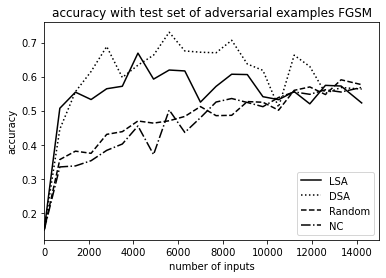

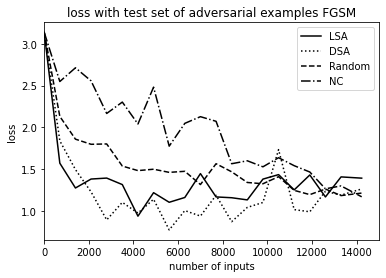

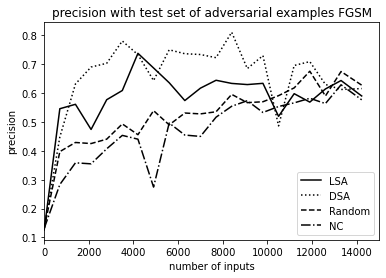

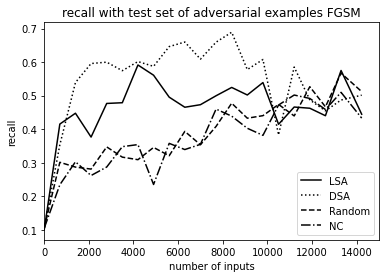

In [41]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#metric = "accuracy" # accuracy loss
my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_0[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_0[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_0[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_0[metric],colors[3],linestyle=linestyles[3])


    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#
    plt.title(metric + " with test set of adversarial examples FGSM")
    plt.xlim([0, 15000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("intel_c2_"+metric + "_0.svg")
    plt.show()

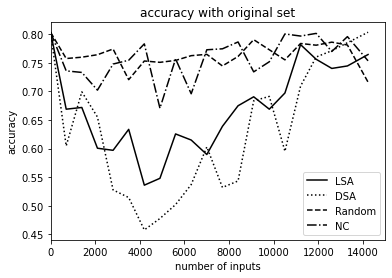

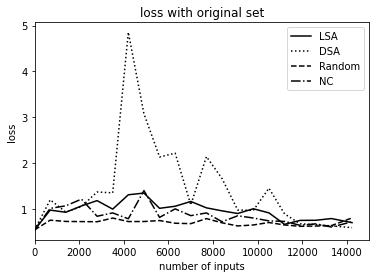

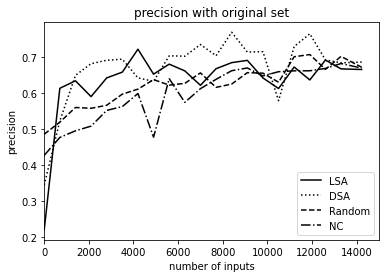

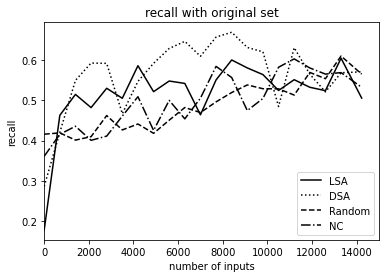

In [42]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    
#metric = "accuracy" # accuracy loss
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_1[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_1[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_1[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_1[metric],colors[3],linestyle=linestyles[3])

    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#
    plt.title(metric + " with original set")
    plt.xlim([0, 15000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("intel_c2_"+metric + "_1.svg")
    plt.show()

11200 0.6689999997615814
11900 0.695000022649765
13300 0.6859999895095825
11200 0.6759999990463257


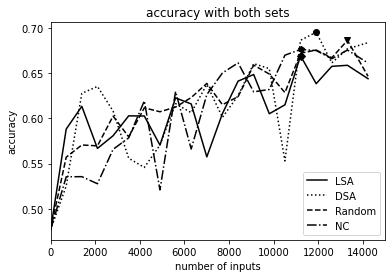

In [43]:
#adversarial jsma test set
#configuration 3
"""
6) Incremental guided retraining starting from the original model using only the new adversarial inputs.
Incremental training, starting with the previous trained model. Using at each iteration a subset of the new inputs.
"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


plt.plot(n_inputs,accuracy_c3_lsa_3,colors[0],linestyle=linestyles[0])
plt.plot(n_inputs,accuracy_c3_dsa_3,colors[1],linestyle=linestyles[1])
plt.plot(n_inputs,accuracy_c3_random_3,colors[2],linestyle=linestyles[2])
plt.plot(n_inputs,accuracy_c3_nc_3,colors[3],linestyle=linestyles[3])


legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



plt.legend(handles=legend_elements)#

plt.title("accuracy with both sets")

print(n_inputs[np.argmax(accuracy_c3_lsa_3)],accuracy_c3_lsa_3.max())
print(n_inputs[np.argmax(accuracy_c3_dsa_3)],accuracy_c3_dsa_3.max())
print(n_inputs[np.argmax(accuracy_c3_random_3)],accuracy_c3_random_3.max())
print(n_inputs[np.argmax(accuracy_c3_nc_3)],accuracy_c3_nc_3.max())

plt.plot(n_inputs[np.argmax(accuracy_c3_lsa_3)],accuracy_c3_lsa_3.max(),'-kD')
plt.plot(n_inputs[np.argmax(accuracy_c3_dsa_3)],accuracy_c3_dsa_3.max(),'-ko')
plt.plot(n_inputs[np.argmax(accuracy_c3_random_3)],accuracy_c3_random_3.max(),'-kv')
plt.plot(n_inputs[np.argmax(accuracy_c3_nc_3)],accuracy_c3_nc_3.max(),'-kp')

plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.xlim([0, 15000])
#plt.ylim([0, 1])

plt.savefig("intel_c2_"+"accuracy" + "_both.svg")

plt.show()

In [33]:
print(accuracy_c3_lsa_5k_3)
print(accuracy_c3_dsa_5k_3)
print(accuracy_c3_random_5k_3)
print(accuracy_c3_nc_5k_3)


[0.55466667]
[0.54416665]
[0.5795]
[0.6015]


## Saving models

In [14]:
new_model_lsa_dir  = "D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2"
i=0

for model in models_lsa:
    model.save(new_model_lsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_lsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/int

In [18]:
new_model_dsa_dir  = "D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2"
i=0
for model in models_dsa:
    model.save(new_model_dsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_dsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/int

In [19]:
new_model_random_dir  = "D:/models/intel_models/C2/intel_model_c2_sep_random_e2"

i=0
for model in models_random:
    model.save(new_model_random_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_random_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/mo

In [17]:
new_model_nc_dir  = "D:/models/intel_models/C2/intel_model_c2_sep_nc_e2"

i=0
for model in models_nc:
    model.save(new_model_nc_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model_c2_sep_nc_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/intel_models/C2/intel_model